# EEG Prepocessing in Python
### Group members: Yen-Chen Lu & Tsu-Yueh Hsu

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import mne
import mne_bids
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs)
from IPython.display import display

In [2]:
%matplotlib qt

## Open dataset (OpenNeuro)
### __[EEG data from an auditory oddball task](https://openneuro.org/datasets/ds003061/versions/1.1.2)__


- 3 identical sessions (13 min each)
- 750 stimuli
    - 70% standard (500 Hz pure tone, 60 ms)
    - 15% oddball (1000 Hz pure tone, 60 ms)
    - 15% distractors (1000 Hz white noise, 60 ms)
- Respond to oddball by pressing a key

## Read the raw data

In [10]:
# Read the set file
raw_path = './oddball/sub-001/eeg'
raw = mne.io.read_raw_eeglab(raw_path + "/sub-001_task-P300_run-1_eeg.set", preload = True)
display(raw.info)

<ipython-input-10-9954c8d6d18c>:3: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + "/sub-001_task-P300_run-1_eeg.set", preload = True)
<ipython-input-10-9954c8d6d18c>:3: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + "/sub-001_task-P300_run-1_eeg.set", preload = True)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 65 EEG, 11 misc, 2 Galvanic skin response, 1 RESP
 custom_ref_applied: False
 dig: 68 items (3 Cardinal, 65 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 79
 projs: []
 sfreq: 256.0 Hz
>

In [12]:
# Extract events and event id (a dictionary mapping string descriptions to integer)
events, event_id = mne.events_from_annotations(raw)
display(events, event_id)

Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard']


array([[  1139,      0,      7],
       [  1346,      0,      7],
       [  1604,      0,      7],
       ...,
       [193483,      0,      6],
       [193644,      0,      7],
       [193897,      0,      7]])

{'ignore': 1,
 'noise': 2,
 'noise_with_reponse': 3,
 'oddball': 4,
 'oddball_with_reponse': 5,
 'response': 6,
 'standard': 7}

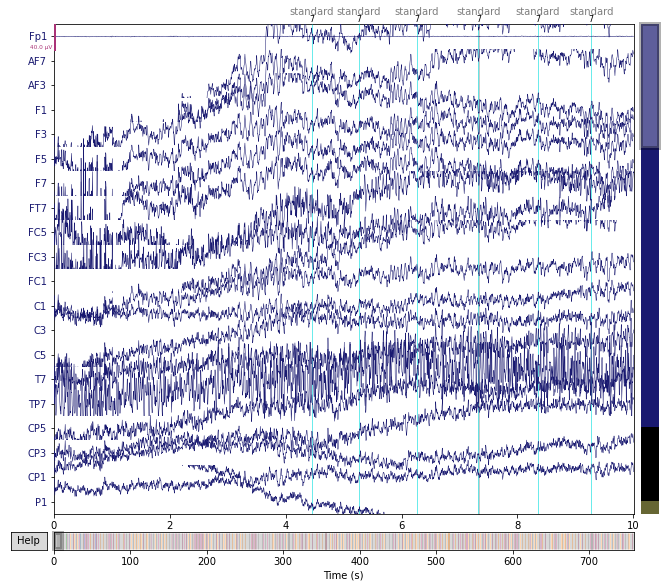

In [24]:
# Visualize the raw data
%matplotlib inline
raw.plot(events = events, color = dict(eeg = 'midnightblue'));

## Select only a subset of the channels

In [35]:
# Channel types
# Show all channels before subsetting
channels_by_type = []
channel_indices = mne.channel_indices_by_type(raw.info)
for k, v in channel_indices.items():
    if v != []:
        channel_names = []
        for i in v:
            # Replace indices by actual channel names
            channel_names.append(raw.ch_names[i])
        channels_by_type.append((k, channel_names))
print(channels_by_type)

[('eeg', ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']), ('misc', ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Erg1', 'Erg2', 'Plet']), ('resp', ['Resp']), ('gsr', ['GSR1', 'GSR2'])]


In [36]:
# Number of channels before subsetting
ch_names = raw.ch_names 
len(ch_names)

79

In [37]:
# Select only a subset of the channels (only eeg channels)
raw_eeg = raw.copy()
raw_eeg.pick_types(meg = False, eeg = True, eog = True, exclude = [])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<RawEEGLAB | sub-001_task-P300_run-1_eeg.set, 65 x 194048 (758.0 s), ~96.3 MB, data loaded>

In [38]:
# Number of channels after subsetting
len(raw_eeg.ch_names)

65

## Visualize the sensor locations

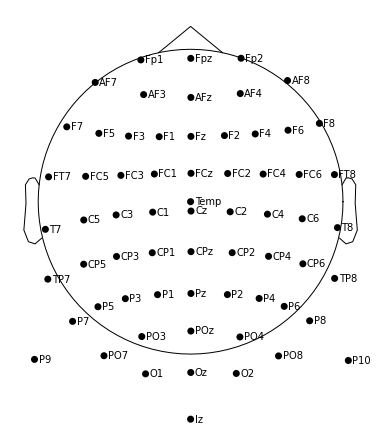

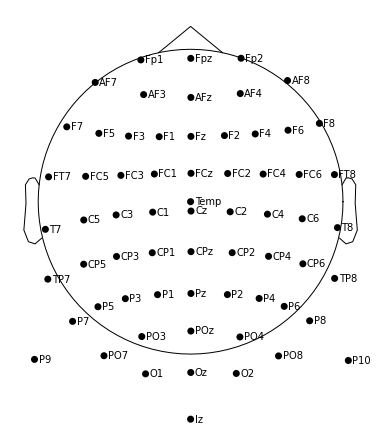

In [39]:
# In 2D
mne.viz.plot_sensors(raw.info, kind = 'topomap', ch_type = 'all', show_names = True)

## Referencing
We chose T7 and T8 as our referenced electrodes for our data. (Since there are no M1 and M2 channels in our data.)

UPDATE:

Initially T7 and T8 were chosen as the referenced electrodes since there are no M1 and M2 channels in the data.
But inspection by eye shows that T7 and T8, being around the temples are quite noisy.
TA **Amanda Lin** therefore suggested we re-reference the data to the **average of all EEG electrodes**.

In [40]:
# Referencing to the average of all channels as T7 and T8 apear to be quite noisy
raw_ref = raw_eeg.copy()
raw_ref.set_eeg_reference(ref_channels = 'average', ch_type = 'eeg')

Applying average reference.
Applying a custom ('EEG',) reference.


<RawEEGLAB | sub-001_task-P300_run-1_eeg.set, 65 x 194048 (758.0 s), ~96.3 MB, data loaded>

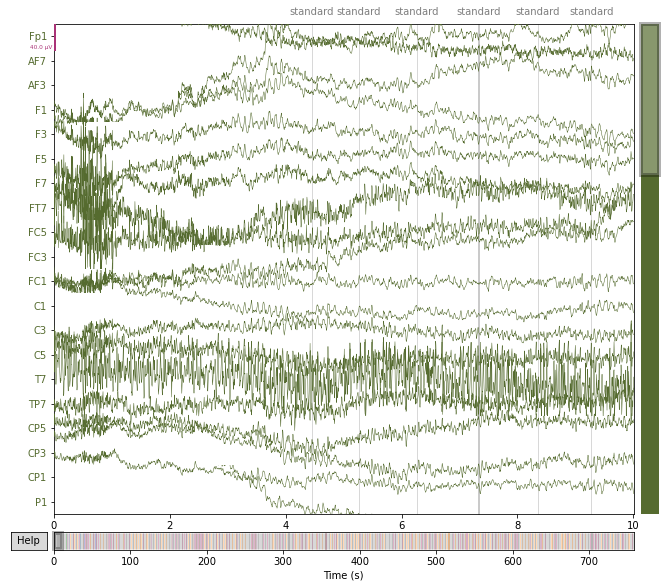

<ipython-input-44-b327cbe9cd78>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ref_fig.show()


In [44]:
# This version of re-referencing looks much cleaner than that to T7 & T8, thanks to the suggestion from Amanda <3
ref_fig = raw_ref.plot(color = dict(eeg = 'darkolivegreen'))
ref_fig.show()

## Filtering

In [ ]:
# Plot the power spectrum before filtering
figure, axes = plt.subplots(1,1)
raw_reref.compute_psd().plot(axes=axes, picks='eeg')
'''You can easily see a spike at around 50 Hz, which is the poweline noise picked up by the electrodes
   (the frequency can vary from country to country; it's usually 50 Hz in Europe and 60 in Taiwan, if I remember correctly)
   However, I do not know why left frontal channels seem to be more affected by such noise.'''
   
axes.axvline(x=50, color='black', linestyle='dashed', linewidth=0.8, label='power line noise')
axes.legend(loc='lower left', bbox_to_anchor=(0.5,0.01))
plt.show()

'''Not excatly sure why this plot is helpful as I've never performed time-frequency analysis'''
raw_reref.compute_psd().plot_topomap(bands=None, cmap='Blues')

Effective window size : 8.000 (s)


<ipython-input-60-a946f3320b0a>:3: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  raw_ref.compute_psd().plot(axes = axes, picks = 'eeg')
/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


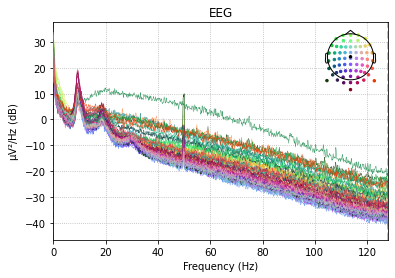

In [60]:
# Plot the power spectrum before filtering
figure, axes = plt.subplots(1, 1)
raw_ref.compute_psd().plot(axes = axes, picks = 'eeg')

plt.show()
# From the plot we can see that there is a spike at around 50 Hz, which may due to the power line noise

Effective window size : 8.000 (s)


<ipython-input-62-194bd2137176>:3: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  raw_ref.compute_psd().plot(axes = axes, picks = 'eeg')
/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


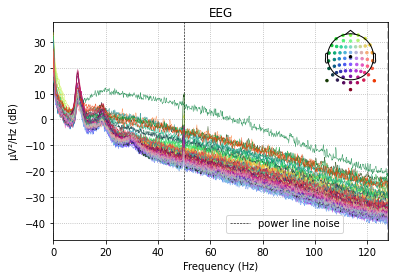

In [62]:
# Plot the power spectrum before filtering + indicating the 50 Hz power line noise
figure, axes = plt.subplots(1, 1)
raw_ref.compute_psd().plot(axes = axes, picks = 'eeg')

axes.axvline(x = 50, color = 'black', linestyle = 'dashed', linewidth = 0.6, label = 'power line noise')
axes.legend(loc = 'lower left', bbox_to_anchor = (0.5, 0.01))
plt.show()

Effective window size : 8.000 (s)


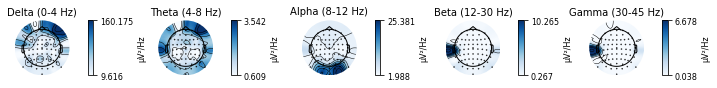

In [64]:
# Topomaps
raw_ref.compute_psd().plot_topomap(bands = None, cmap = 'Blues');

In [67]:
# Using a band pass filter from 0.16-30 Hz
raw_ref_filt = raw_ref.copy()

# Filtering using the IIR Butterworth of 2nd order
iir_params = dict(order = 2, ftype = 'butter', output = 'sos') 
raw_ref_filt = raw_ref_filt.filter(l_freq = 0.1, h_freq = 30, method = 'iir', iir_params = iir_params)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB



### Compare before and after filtering

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


<ipython-input-70-3d66d31f63a0>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


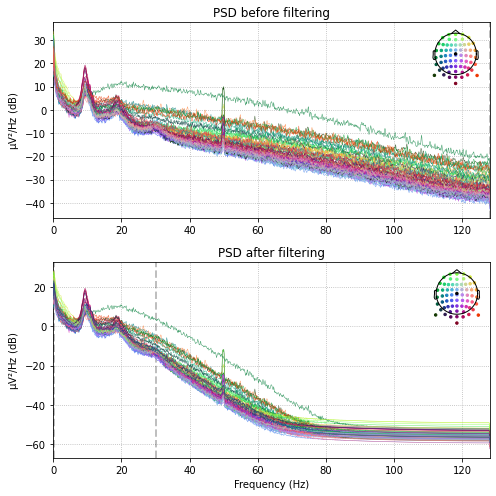

In [70]:
fig, ax = plt.subplots(2, figsize = (7, 7))

# Plot PSD before filtering
raw_ref.plot_psd(ax = ax[0], picks = ['eeg'], show = False)
ax[0].set_title('PSD before filtering')

# Plot PSD after filtering
raw_ref_filt.plot_psd(ax = ax[1], picks = ['eeg'], show = False)
ax[1].set_title('PSD after filtering')

# Set x-axis label
ax[1].set_xlabel('Frequency (Hz)')

# Adjust layout and show the figure
fig.tight_layout()
plt.show()

Effective window size : 8.000 (s)
Effective window size : 8.000 (s)


<ipython-input-80-efc13f91bd37>:4: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  raw_ref.compute_psd().plot(axes = ax[0], picks = ['eeg'], show = False)
<ipython-input-80-efc13f91bd37>:10: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  raw_ref_filt.compute_psd().plot(axes = ax[1], picks = ['eeg'], show = False)
<ipython-input-80-efc13f91bd37>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


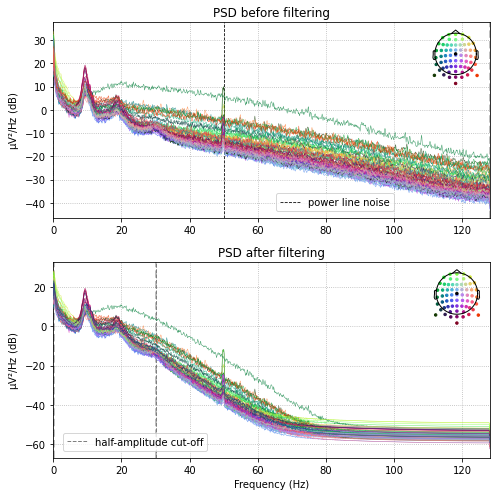

In [80]:
fig, ax = plt.subplots(2, figsize = (7, 7))

# Plot PSD before filtering
raw_ref.compute_psd().plot(axes = ax[0], picks = ['eeg'], show = False)
ax[0].set_title('PSD before filtering')
ax[0].axvline(x = 50, color = 'black', linestyle = 'dashed', linewidth = 0.8, label = 'power line noise')
ax[0].legend(loc = 'lower left', bbox_to_anchor = (0.5, 0.01))

# Plot PSD after filtering
raw_ref_filt.compute_psd().plot(axes = ax[1], picks = ['eeg'], show = False)
ax[1].set_title('PSD after filtering')
ax[1].axvline(x = 30, color = 'grey', linestyle = 'dashed', linewidth = 1.0, label = 'half-amplitude cut-off')
ax[1].legend(loc = 'lower left', bbox_to_anchor = (0.01, 0.01))

# Set x-axis label
ax[1].set_xlabel('Frequency (Hz)')

# Adjust layout and show the figure
fig.tight_layout()
plt.show()

### Zoom in 

Effective window size : 8.000 (s)


<ipython-input-77-d65667db41dd>:1: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  raw_ref_filt.compute_psd(fmax = 50).plot();
/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


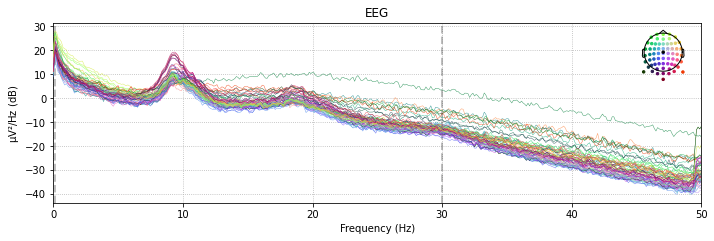

In [77]:
raw_ref_filt.compute_psd(fmax = 50).plot();

## Extract events from annotations

In [85]:
# Get events and event ids from annotations
events, event_id = mne.events_from_annotations(raw_ref_filt)
display(len(events))
display(event_id)

Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard']


863

{'ignore': 1,
 'noise': 2,
 'noise_with_reponse': 3,
 'oddball': 4,
 'oddball_with_reponse': 5,
 'response': 6,
 'standard': 7}

## Creating epochs for the events

In [86]:
# Rejecting epochs with peak-to-peak amplitude +/-100 µV
reject_criteria = dict(
    eeg = 100e-6,  # 100 µV
)  

In [88]:
# Epochs will start 200 ms before the stimulus onset and end 
# 600 ms after stimulus onset
tmin = -0.2
tmax = 0.6

# Baseline correction
baseline = (-0.2, 0)

epochs = mne.Epochs(raw_ref_filt,
                    events = events,
                    event_id = event_id,
                    reject = reject_criteria,
                    tmin = tmin,
                    tmax = tmax,
                    baseline = baseline,
                    preload = True)
epochs

Not setting metadata
863 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 863 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Rejecting  epoch based on EEG : ['T7', 'P9', 'P10']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7', 'P10']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7', 'Fpz', 'Fp2', 'AF8', 'T8']
    Rejecting  epoch based on EEG : ['T7', 'P2']
    Rejecting  epoch based on EEG : ['T7', 'P2']
    Rejecting  epoch based on EEG : ['T7', 'Fpz', 'AF8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : [

<Epochs |  730 events (all good), -0.199219 – 0.601562 s, baseline -0.2 – 0 s, ~74.7 MB, data loaded,
 'ignore': 0
 'noise': 99
 'noise_with_reponse': 1
 'oddball': 0
 'oddball_with_reponse': 93
 'response': 95
 'standard': 442>

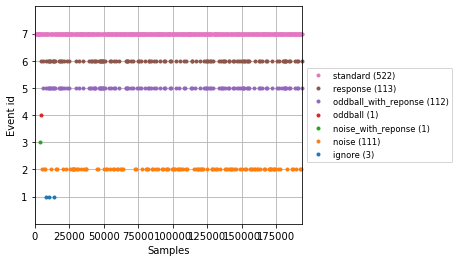

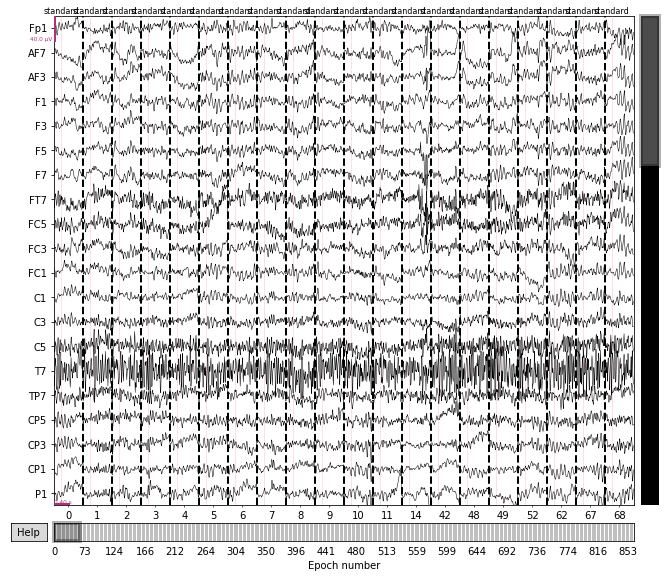

<ipython-input-98-f69a9416954d>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_events.show()
<ipython-input-98-f69a9416954d>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_epochs.show()


In [98]:
fig_events = mne.viz.plot_events(events, event_id = event_id);
fig_epochs = epochs['standard', 'oddball_with_response'].plot(events = events, event_color={'standard':'pink', 'oddball_with_reponse':'red'}, event_id = event_id);
       
fig_events.show()
fig_epochs.show()

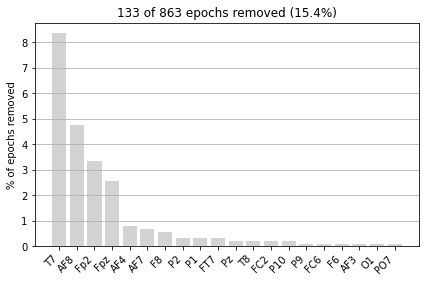

In [100]:
%matplotlib inline
mne.viz.plot_drop_log(epochs.drop_log);

In [115]:
type(ax[0, 1])

matplotlib.axes._subplots.AxesSubplot

Not setting metadata
442 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


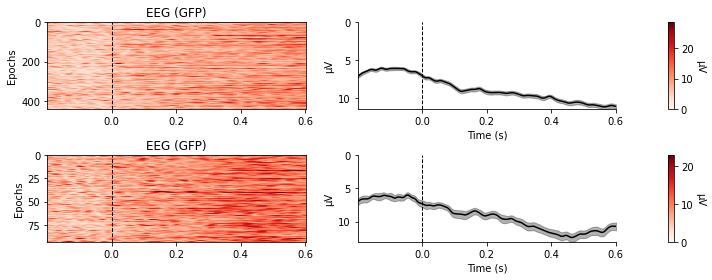

In [118]:
%matplotlib inline
fig, ax = plt.subplots(2,3, figsize = (10,4), gridspec_kw = {'width_ratios': [7,7,.15]})

# standard
epochs['standard'].plot_image(axes = ax[0], fig = None, colorbar = True, evoked = True, show = False)
ax[0, 0].invert_yaxis()
ax[0, 1].invert_yaxis()

# oddball with response
epochs['oddball_with_reponse'].plot_image(axes = ax[1], fig = None, colorbar = True, evoked = True, show = False)
ax[1, 0].invert_yaxis()
ax[1, 1].invert_yaxis()

fig.tight_layout()
plt.show()

## Creating evoked data

Creating evoked responses for each condition

In [119]:
evoked_standard = epochs['standard'].average()
evoked_oddball_resp = epochs['oddball_with_reponse'].average()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(12,4))
for i, x in enumerate(evokeds):
    plot_evoked(x, picks=picks, spatial_colors=True, axes=axes.flatten()[i], show=False);
    axes[i].axvline(x=0, color='black', linewidth=0.5)
    axes[i].axhline(y=0, color='black', linewidth=0.5)
    axes[i].invert_yaxis()
plt.show()

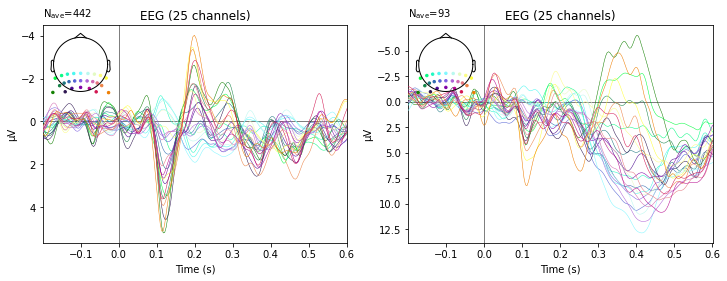

In [121]:
fig, ax = plt.subplots(1, 2, figsize = (12,4))

# Only look at the posterior channels because P3b is more prominent there (suggested by TA Amanda Lin)
picks = [ch for ch in raw_eeg.ch_names if 'P' in ch]

# standard 
mne.viz.plot_evoked(evoked_standard, picks = picks, spatial_colors = True, axes = ax.flatten()[0], show = False);
ax[0].axvline(x = 0, color = 'black', linewidth = 0.5)
ax[0].axhline(y = 0, color = 'black', linewidth = 0.5)
ax[0].invert_yaxis()

# oddball with response
mne.viz.plot_evoked(evoked_oddball_resp, picks = picks, spatial_colors = True, axes = ax.flatten()[1], show = False);
ax[1].axvline(x = 0, color = 'black', linewidth = 0.5)
ax[1].axhline(y = 0, color = 'black', linewidth = 0.5)
ax[1].invert_yaxis()

plt.show()

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


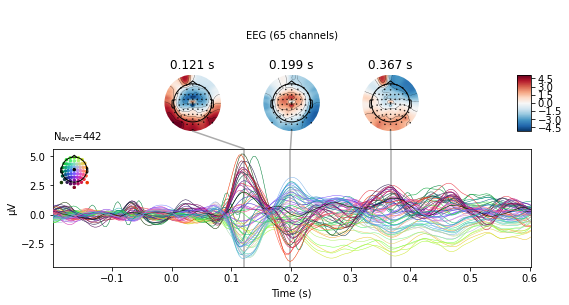

In [122]:
evoked_standard.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


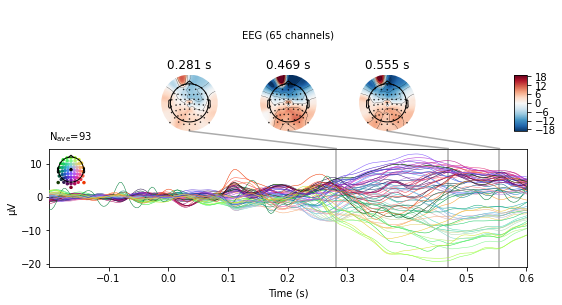

In [123]:
evoked_oddball_resp.plot_joint();


Robust P3b effects seen at the means of C1+C2/2, CP1+CP2/2, and P1+P2/2, and perhaps a bit at O1+O2/2



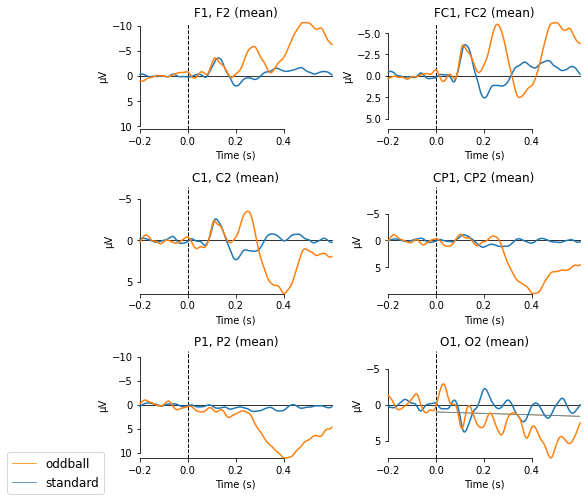

In [125]:
# Out original code (we plotted for all EEG channels)
# mne.viz.plot_compare_evokeds([evoked_standard, evoked_oddball_resp]);

# Modified version from TA Amanda Lin:
ch_to_plot = [['F1','F2'],['FC1','FC2'],['C1','C2'],['CP1','CP2'],['P1','P2'],['O1','O2']]

figure, axes = plt.subplots(3,2, figsize = (7,7))
from IPython.utils import io
with io.capture_output() as captured:
    for i, ch in enumerate(ch_to_plot):
        figs = mne.viz.plot_compare_evokeds([evoked_standard, evoked_oddball_resp], picks = ch,
                                    combine = 'mean', axes = axes.flatten()[i], legend = False)[0]
for ax in figs.axes:
    ax.invert_yaxis()

line_1, = ax.plot([1, 2, 3], label = 'oddball', linewidth = 0.8, color = 'darkorange')
line_2, = ax.plot([1, 2, 3], label = 'standard', linewidth = 0.8, color = 'steelblue')
figs.legend(handles = [line_1, line_2], loc = 'lower left', fontsize = '12', bbox_to_anchor = [-0.17, 0.00001])
figs.tight_layout()
print('\nRobust P3b effects seen at the means of C1+C2/2, CP1+CP2/2, and P1+P2/2, and perhaps a bit at O1+O2/2\n')
display(figs)

## Preprocessing function

In [129]:
def eeg_prepross(subj, run):
    # get subj number (e.g., 001, 002, 003...)
    sub_num = subj
    
    # Read the set file
    raw_path = f"./oddball/sub-{sub_num}/eeg"
    raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
    
    # Select only a subset of the channels (only EEG channels)
    raw_eeg = raw.copy().pick_types(meg = False, eeg = True, eog = True, exclude = [])
    
    # Referencing using the average of all EEG channels as the referenced electrode
    raw_ref = raw_eeg.copy().set_eeg_reference(ref_channels = 'average')
    
    # Get events and event ids from annotations
    events, event_id = mne.events_from_annotations(raw_ref)
    
    # Create epoch for the events
    # Epochs will start 200 ms before the stimulus onset and end 
    # 600 ms after stimulus onset
    tmin = -0.2
    tmax = 0.6
    baseline = (-0.2, 0)
    
    # Rejecting epochs with peak-to-peak amplitude +/-100 µV
    reject_criteria = dict(
        eeg = 100e-6,  # 100 µV
    )  

    # The Epoch object is created using the raw object prior filtering (as suggested by TA Amanda Lin)
    epochs = mne.Epochs(raw_ref,
                        events = events,
                        event_id = event_id,
                        reject = reject_criteria,
                        tmin = tmin,
                        tmax = tmax,
                        baseline = baseline,
                        preload = True)
    
    # Using a band pass filter from 0.16-30 Hz using IIR Butterworth
    iir_params = dict(order = 2, ftype = 'butter', output = 'sos')
    raw_ref_filt = raw_ref.copy().filter(l_freq = 0.16, h_freq = 30, method = 'iir', iir_params = iir_params)
    
    evoked_standard, evoked_oddball_resp = epochs['standard'].average(), epochs['oddball_with_reponse'].average() 
    
    return(evoked_standard, evoked_oddball_resp)
       

### Looping over all 13 subjects, each with their 3 runs compiled

In [130]:
# Loop over all 13 subjects to do the pre-processing for all three runs

evoked_dict = {}
# {
#     '001': [run1, run2, run3],
#     '002': [run1, run2, run3], 
#     ...
#     '013': [run1, run2, run3]

# }

# run1[0] = standard
# run1[1] = oddball

sub_index = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013']
runs = range(1, 4)

for subj in sub_index:
    subj_runs = []
    for run in runs:
        subj_runs.append(eeg_prepross(subj, run))
    evoked_dict[subj] = subj_runs


<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
863 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 863 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['T7', 'P10']
    Rejecting  epoch based on EEG : ['T7', 'P10']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7', 'P10']
    Rejecting  epoch bas

    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['T7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['P1']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG 

    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecti

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['noise', 'noise_with_reponse', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
862 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 862 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['P1']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EE

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
860 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'F1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Rejecting  epoch based on EEG : ['FT7', 'T7', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'T7', 'Fpz', 'Fp2', 'AF8', 'T8', 'P10']
    Rejecting  epoch based on EEG : ['FT7', 'T7', 'P9', 'T8', 'P10']
    Rejecting  epoch based on EEG : ['T7']
 

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['AF7', 'P8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8']
    Rejecting  epoch based on EEG : ['AF8', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AFz']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based 

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Not setting metadata
812 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 812 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F6', 'FC2', 'P8']
    Rejecting  epoch based on EEG : ['FC5', 'P5', 'P7', 'AF8', 'F6', 'FC2', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'FC2']
    Rejecting  epoch based on EEG : ['P5', 'AF8', 'F6', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC2', 'P10']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['F6', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC2', 'TP8']
    Rejecting  epoch based

    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC2', 'P10']
    Rejecting  epoch based on EEG : ['TP7', 'P7', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F6', 'P10']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC2', 'P10']
    Rejecting  epoch based on EEG : ['F3', 'P5', 'P7', 'FC2']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'P9', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'F6', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'AF8', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['F6', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC2', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'FC2', 'TP8', 'P10']
    Rej

    Rejecting  epoch based on EEG : ['AF8', 'F6', 'FC2', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['P5', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['FC5', 'P7', 'F4']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'F6', 'FC2', 'P10']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'Oz', 'F6']
    Rejecting  epoch based on EEG : ['F3', 'FT7', 'P7', 'F4', 'F6', 'FC2', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'F6', 'FC2', 'TP8', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'F6']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'F6']
    Rejecting  epoch based on EEG : ['F1', 'F3', 'P7', 'Fpz', 'Fp2', 'AF8', 'F4', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'F6', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'FC2', 'TP8', 'P8']
    Rejecting  epoch

    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'F5', 'FT7', 'C5', 'T7', 'TP7', 'CP5', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'CPz', 'AF8', 'Fz', 'F6', 'FT8', 'FC6', 'FC4', 'FC2', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F6', 'FT8', 'T8', 'TP8', 'CP6']
    Rejecting  epoch based on EEG : ['FT7', 'FC5', 'P5', 'P7', 'F4', 'F6', 'T8', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['F3', 'F5', 'F7', 'FT7', 'FC5', 'C5', 'T7', 'CP5', 'P7', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'P6', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'P7', 'P9', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'P10', 'O2']
    Rejecting  epoch based on EEG : ['F3', 'F5', 'F7', 'FT7', '

    Rejecting  epoch based on EEG : ['P5', 'P7', 'F6', 'FC2', 'TP8', 'CP6', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'TP8']
    Rejecting  epoch based on EEG : ['F6', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'P7', 'F6']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'F6', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'TP8']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'F6', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F6', 'FC2', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Fp2', 'AF8', 'F4', 'F6', 'FC2', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Fp2', 'AF8', 'F6', 'FC2', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'P5', 'P7', 'AF8', 'F6', 'FC2', 'TP8', 'P6']
    Rejecting  epoch based on EEG : ['AF7

    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC2', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejec

    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC4', 'FC2', 'C2', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'FC4', 'FC2', 'C2', 'P8']
    Rejecting  epoch based on EEG : ['F3', 'P3', 'P7', 'AF8', 'F4', 'F6', 'FC4', 'FC2', 'C2', 'TP8']
    Rejecting  epoch based on EEG : ['FC5', 'P7', 'F6', 'FC4', 'FC2', 'C2', 'P10']
    Rejecting  epoch based on EEG : ['P5', 'P7', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'T7', 'TP7', 'CP3', 'P1', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C6', 'T8', 'TP8', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'F6', 'FC4', 'FC2', 'C2', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'AF8', 'F6', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG 

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'C3', 'C5', 'T7', 'P7', 'AF8', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P6', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6',

    Rejecting  epoch based on EEG : ['AF7', 'P7', 'F4', 'F6', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 'FT7', 'P7', 'Oz', 'F4', 'F6', 'FC4', 'FC2', 'C2', 'P6', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['F3', 'F6', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['F3', 'F4', 'F6', 'FC4', 'FC2', 'C2', 'TP8']
    Rejecting  epoch based on EEG : ['F3', 'F5', 'P7', 'F6', 'FC4', 'C2', 'TP8', 'P6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : 

    Rejecting  epoch based on EEG : ['FC5', 'P5', 'P7', 'AF8', 'F6', 'F8', 'FT8', 'FC4', 'FC2', 'C2', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'AF8', 'F6', 'FC4', 'FC2', 'C2', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'AF8', 'F6', 'FC4', 'FC2', 'C2', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC4', 'FC2', 'C2', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'P5', 'P7', 'AF8', 'F6', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['AF3', 'P7', 'AF8', 'F6', 'FC4', 'FC2', 'C2']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F6', 'FC4', 'FC2', 'C2', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F6', 'FC4', 'FC2', 'C2', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F6', 'FC4', 'FC2', 'C2', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC4', 'FC2', 'C2', 'C6']
    Rejecting  epoch based on EEG : ['P7', 'F6', 'FC4', 'FC2', 'C2', 'TP8', 'P10']
    Rejecting  epoch based on EEG

/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-129-23b2e453314a>:44: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evoked_standard, evoked_oddball_resp = epochs['standard'].average(), epochs['oddball_with_reponse'].average()
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
807 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 807 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF3', 'P7', 'TP8', 'P10', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'P7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F2', 'P10', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Oz', 'Fpz', 'Fp2', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'AF8', 'FT8', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['P3', 'P7

    Rejecting  epoch based on EEG : ['P7', 'F4', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'F4']
    Rejecting  epoch based on EEG : ['FT7', 'P7']
    Rejecting  epoch based on EEG : ['P7', 'P6']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P4', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'TP8', 'P1

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


    Rejecting  epoch based on EEG : ['P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F4', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'P6', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P1', 'P3', 'P7', 'Oz', 'POz', 'TP8', 'P6', 'P8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['P1', 'P7', 'F4', 'P8', 'PO4']

    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'Fz', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'AFz', 'Fz', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'P9', 'Fz', 'FC6', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'FC6', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'Fz', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['TP7', 'P7', 'Fz', 'TP8', 'PO4']
    Re

    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'P6', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'Fz', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'Fz', 'FT8', 'CP2', 'P6', 'P8', 'P10', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'P6']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['F7', 'P7', 'Fz', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'Iz', 'Oz', 'Fp2', 'AF8', 'Fz', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'C4', 'C6', 'T8', 'TP8', 'P8']
    Rejecting  epoch based on EEG : [

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'C3', 'C

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'Fp2', 'Fz', 'TP8', 'P8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'Fz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'Fz', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'P7', 'Fp2', 'A

    Rejecting  epoch based on EEG : ['P7', 'Fz', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'F2', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'AF8', 'Fz', 'F2', 'FT8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'Fz', 'TP8', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'Fz', 'PO4']
    Rejecting  epoch based on EEG : ['Fz', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'Fz', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'AF8', 'Fz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'P8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'P9', 'Oz', 'AF8', 'Fz',

    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'P6', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Iz', 'Fz', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Oz', 'Fz', 'C4', 'TP8']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'TP8']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'TP8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'CP5', 'P3', 'P7', 'P9', 'Iz', 'POz', 'Fpz', 'AF8', 'Fz', 'F2', 'F6', 'TP8', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Iz', 'Fz', 'F4', 'FT8', 'FC4', 'TP8', 'CP2', 'P2', 'P6', 'P8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'TP8', 'P6']
    Rejecting  epoch based on EEG : ['P7', 'F

    Rejecting  epoch based on EEG : ['P7', 'Fz', 'F4', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'P6', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Fz', 'P6', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Oz', 'AF8', 'Fz', 'P6', 'P8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Iz', 'AF8', 'Fz', 'F4', 'TP8', 'P6', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'TP8', 'P6', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'TP8', 'P6', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'P7', 'Fz', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'P7', 'Fz', 'P6', 'P8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fz', 'P6', 'PO4']
    Rejecting  epoc

/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-129-23b2e453314a>:44: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evoked_standard, evoked_oddball_resp = epochs['standard'].average(), epochs['oddball_with_reponse'].average()
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
799 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 799 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Fpz', 'Fp2', 'AF8', 'F4', 'F6', 'T8', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'TP8', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'PO7', 'AF8', 'TP8', 'O2']
    Rejecting  epoch based on EEG : ['P7', 'PO7', 'TP8', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'P8']


    Rejecting  epoch based on EEG : ['P7', 'FT8']
    Rejecting  epoch based on EEG : ['P7', 'FT8']
    Rejecting  epoch based on EEG : ['F7', 'P7', 'FT8']
    Rejecting  epoch based on EEG : ['P7', 'FT8']
    Rejecting  epoch based on EEG : ['P7', 'TP8']


<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'F4']
    Rejecting  epoch based on EEG : ['AF7', 'P7']
    Rejecting  epoch based on EEG : ['P7', 'PO7', 'AF8', 'TP8', 'P8', 'O2']
    Rejecting  epoch based on EEG : ['AF8', 'P10']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['AF7', 'F4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F4', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'TP8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'P8']
    Rejecting  epoch based

    Rejecting  epoch based on EEG : ['CP5', 'P7']
    Rejecting  epoch based on EEG : ['P7', 'TP8']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'PO7']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'PO7', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'F1', 'FC1', 'C1', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'POz', 'Fz', 'F2', 'F4', 'FC2', 'FCz', 'Cz', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'P7']
    Rejecting  epoch based on EEG : ['AF7', 'FC1', 'P7', 'Fz', 'FC2', 'FCz', 'Cz']
    Rejecting  epoch based on EEG : ['AF7', 'P7'

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'P7', 'AF8', 'F6', 'FT8', 'P8', 'P10', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Fp2', 'AF8', 'F2', 'F4', 'F8', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'PO7', 'Iz', 'Oz', 'AF8', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'T8', 'TP8', 'P6', 'P10', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'TP7', 'CP5', 'P7', 'P9', 'PO7', 'Fpz', 'Fp2', 'AF8', 'F6', 'FT8', 'TP8', 'P8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'P7', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AFz', 'FT8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F4', 'FT8', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'F4', 'FT8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'PO4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : [

    Rejecting  epoch based on EEG : ['AF7', 'P7', 'F4', 'FT8', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'P9', 'F6']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'P7', 'P9', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'P9', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Oz', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'P7']
    Rejecting  epoch based on EEG : ['AF7', 'P7']
    Rejecting  epoch based on EEG : ['AF7', 'P7']
    Rejecting  epoch based on EEG : ['AF7', 'T7', 'P7', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8', 'PO4']
    Rejecting  epoch based

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'P3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'T7', 'P7', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'C6', 'T8', 'TP8', 'CP6', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'AF8', 'F6',

    Rejecting  epoch based on EEG : ['AF7', 'F5', 'P7', 'F4', 'TP8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'C5', 'P7', 'C6', 'T8', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'CP5', 'P7', 'C6', 'TP8', 'CP6', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'P7', 'C6', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'T7', 'CP5', 'P7', 'C6', 'TP8', 'CP6']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'C6', 'TP8', 'CP6']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'P7', 'FT8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'T8', 'TP8', 'CP6']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'TP8']
796 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass z

/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-129-23b2e453314a>:44: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evoked_standard, evoked_oddball_resp = epochs['standard'].average(), epochs['oddball_with_reponse'].average()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']


<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Not setting metadata
861 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 861 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['Iz']
    Rejecting  epoch based on EEG : ['Iz']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
  

    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF8', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['AF8', 'Fz', 'FT8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'AF8', 'C4']
    Rejecting  epoch based on EEG : ['FC2', 'P10']
    Rejecting  epoch based on EEG : ['AF8', 'FC2']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['AF8', 'FC2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['AF8', 'P10']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
860 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'FC2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'AF8', 'P6']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'FC2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'POz', 'Fpz', 'Fp2', 'AF8', 'F2', 'FC2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['F5', 'Fpz', 'Fp2', 'A

    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FT8', 'FC2']
    Rejecting  epoch based on EEG : ['FC1', 'FT8', 'FC2']
    Rejecting  epoch based on EEG : ['F2', 'FT8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['AF3', 'Fz', 'P6']
    Rejecting  epoch based on EEG : ['FT8', 'FC2']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['POz', 'FC2']
    Rejecting  epoch based on EEG : ['POz', 'P6']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['FT8', 'P2']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['POz', 'Fz', 'FT8', 'FC2', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'POz', 'Fz', 'FT8', 'FC2']
    Re

    Rejecting  epoch based on EEG : ['POz', 'AF8']
    Rejecting  epoch based on EEG : ['POz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['POz', 'AF8', 'AFz', 'F6', 'FT8', 'FC2', 'P10']
    Rejecting  epoch based on EEG : ['POz', 'Fpz', 'AF8', 'F4', 'F6', 'P10']
    Rejecting  epoch based on EEG : ['POz', 'Fpz', 'AFz', 'F4', 'F8', 'C4', 'P2', 'PO4']
    Rejecting  epoch based on EEG : ['POz', 'FT8', 'P6']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'C3', 'PO7', 'POz', 'Fpz', 'AF8', 'AF4', 'F2', 'F4', 'FC2', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'O1', 'POz', 'Fpz', 'AF8', 'AFz', 'FT8', 'FC2', 'P2']
    Rejecting  epoch based on EEG : ['AF3', 'O1', 'FC2']
    Rejecting  epoch based on EEG : ['AFz', 'FC2']
    Rejecting  epoch based on EEG : ['AF8', 'FC2']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'FC1', 'C3', 'POz', 'Pz', 'AF8', 'F2', 'F6', 'FC2', 'FCz', 'P6', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'Pz', 'F2', 'FCz', 'P2']
    Rejectin

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
861 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 861 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['FC2', 'P6']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'P2']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['P4']


<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
860 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'CPz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC4', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F5', 'C1', 'C5', 'CP3', 'PO7', 'PO3', 'O1', 'Iz', 'Fpz', 'Fz', 'F2', 'F6', 'FT8', 'Cz', 'C4', 'CP6', 'P6', 'P10', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['F5', 'C3', 'POz']
    Rejecting  epoch based on EEG : ['F5', 'C1', 'C3', 'CP3', 'C4', 'T8']
    Rejecting 

    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F5', 'F7', 'CP3', 'PO7', 'PO3', 'Iz', 'Fpz', 'F4', 'F6', 'FT8', 'CP6', 'P6', 'P8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5', 'C3', 'Fpz']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5', 'F7']
    Rejecting  epoch based on EEG : ['F5', 'F7']
    Rejecting  epoch based on EEG : ['F5', 'F7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'FC5', 'C1', 'C3', 'T7', 'TP7', 'P1', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'Fpz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['F5', 'C3']
    Rejecting  epoch based on EEG : ['F5', 'C1', 'Fpz', 'AFz']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'Fpz']
    Rejecting  epoch ba

    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'Fpz', 'PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'F7', 'C3', 'T7', 'P1', 'P5', 'P7', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F4', 'F6', 'FT8', 'C2', 'TP8', 'CP6', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'Fpz', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7']
    Rejecting  epoch based on EEG : ['F5', 'F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7']
    Rejecting  epoch based on EEG : ['F5', 'F7']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7'

    Rejecting  epoch based on EEG : ['F3', 'F5', 'F7', 'C5', 'P5', 'O1', 'Iz', 'Fpz', 'AFz', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'P5', 'Iz', 'Oz', 'Fpz', 'AFz', 'F6', 'FT8', 'CP6', 'P8', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'Fpz', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['F5', 'F7']
    Rejecting  epoch based on EEG : ['F3', 'F5', 'F7']
    Rejecting  epoch based on EEG : ['F3', 'F5', 'F7', 'P9']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['PO7', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'F7', 'FC5', 'C3', 'C5', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'C6', 'CP6', 'P8', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'C5', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'CP6', 'P8', 'P10', 'PO8', 'PO4']


    Rejecting  epoch based on EEG : ['AF3', 'F7', 'Iz', 'Fpz', 'AF4', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'PO4']
    Rejecting  epoch based on EEG : ['Iz', 'Fpz', 'AF4', 'AFz', 'F6', 'FT8', 'T8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 'F5', 'F7', 'Fpz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['F6', 'T8']
    Rejecting  epoch based on EEG : ['F7', 'F6', 'C6', 'T8']
    Rejecting  epoch based on EEG : ['Fpz', 'F6']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['F5', 'F7']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'FT8', 'T8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F5', 'F7', 'C5', 'T7', 'P1', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'AF4', 'AFz', 'F6', 'FT8', 'FC4', 'C6', 

    Rejecting  epoch based on EEG : ['F5', 'F7', 'Fpz', 'AFz', 'FT8']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'Fpz', 'AFz', 'F6', 'FT8', 'PO4']
    Rejecting  epoch based on EEG : ['F7', 'Fpz']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'FC5', 'C3', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AFz', 'F4', 'F6', 'FT8', 'FCz', 'Cz', 'CP6', 'CP2', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'F7', 'C3', 'C5', 'T7', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F4', 'F6', 'FT8', 'FC4', 'C6', 'T8', 'CP6', 'CP2', 'P6', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5', 'O1', 'Fpz', 'F6', 'PO8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'AFz', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'P1', 'P5', 'PO7', 'Iz', 'Oz', 'Fpz'

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
857 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 857 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F3', 'F5', 'F7', 'T7', 'CP1', 'P1', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'FT8', 'FCz', 'C4', 'C6', 'T8', 'CP6', 'CP2', 'P8', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['F5', 'F7']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'C3', 'P9', 'Fp2', 'C6', 'PO4']
    Rejecting  epoch based on EEG : ['Fpz', 'AFz', 'FT8']
    Rejecting  epoch based on EEG : ['F7', 'P9', 'T8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'Fpz', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'P9', 'Fpz', 'AFz', 'F6', 'T8']
 

    Rejecting  epoch based on EEG : ['F5', 'F7']
    Rejecting  epoch based on EEG : ['F5', 'F7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'F7', 'FC5', 'C3', 'T7', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'Iz', 'Oz', 'CPz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'Fz', 'F6', 'FT8', 'FCz', 'C2', 'C6', 'CP6', 'CP2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'Oz', 'Fpz', 'AFz', 'FT8', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'Fpz', 'AFz', 'PO4']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'FT8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'Fpz', 'AFz', 'FT8', 'PO4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'T7', 'P1', 'P5', 'P7', 'P9', 'PO7', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF4', 'AFz', 

    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F5', 'F7', 'C5', 'T7', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F4', 'F6', 'FT8', 'T8', 'TP8', 'CP6', 'CP2', 'P6', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'Iz', 'Fp2', 'C6', 'T8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'P5', 'PO7', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8', 'T8', 'CP6', 'P8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8', 'T8', 'PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'F7', 'C3', 'C5', 'T7', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C6', 'T8', 'CP6', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'F7', 'FC1',

    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'P5', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'Fpz', 'AFz', 'F6', 'P10']
    Rejecting  epoch based on EEG : ['F7', 'Fpz', 'F6']
    Rejecting  epoch based on EEG : ['Fpz', 'F6']
    Rejecting  epoch based on EEG : ['F6', 'P10']
    Rejecting  epoch based on EEG : ['F6', 'T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F6', 'T8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F7', 'PO7', 'O1', 'Iz', 'T8']
    Rejecting  epoch based on EEG : ['C5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'PO7', 'T8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['Fpz', 'AFz', 'F6']
    Reject

    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'Fpz', 'AFz', 'F6', 'T8']
    Rejecting  epoch based on EEG : ['F7', 'Fpz']
    Rejecting  epoch based on EEG : ['F7', 'Fpz', 'T8']
    Rejecting  epoch based on EEG : ['F7', 'T8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'C5', 'T7', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C6', 'T8', 'CP6', 'CP2', 'P2', 'P6', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'FC1', 'C5', 'T7', 'CP3', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'FT8', 'FC4', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP6', 'CP2', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['FT8', 'T8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'T8', 'PO8', 'PO4

    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'P9', 'PO7', 'Iz', 'Fpz', 'AFz', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'P5', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'FT8', 'T8', 'CP6', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'P9', 'PO7', 'O1', 'Fpz', 'AFz', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'P9', 'Fpz', 'Fp2', 'AFz', 'T8', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'FC1', 'C1', 'C5', 'T7', 'CP5', 'CP1', 'P1', 'P3', 'P5', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP6', 'CP2', 'P6', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC1', 'C5', 'T7', 'P1', 'P5', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'Fz', 'F6', 'FT8', 'FC2', 'FCz', 'Cz', 'C2', 'C4', '

    Rejecting  epoch based on EEG : ['AF3', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'C6', 'T8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'P5', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'P8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'C5', 'P5', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'P8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'T7', 'P5', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'FT8', 'C6', 'CP6', 'P8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'Fpz', 'F6']
    Rejecting  epoch based on EEG : ['F6', 'T8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'FC5', 'FC1', 'C5', 'T7', 'P1', 'P3', 'P5', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F6', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP6', 'CP2', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1

    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'F7', 'FT7', 'FC5', 'FC1', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'FT8', 'FCz', 'C4', 'C6', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['CP5', 'O1', 'F6', 'P10']
    Rejecting  epoch based on EEG : ['C5', 'CP3', 'PO7', 'O1', 'Iz', 'F6', 'FC4', 'C6', 'T8', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'F6']
    Rejecting  epoch based on EEG : ['PO3', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F5', 'F7', 'FC5', 'FC1', 'C5', 'T7', 'CP3', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AF4', 'AFz', '

    Rejecting  epoch based on EEG : ['Fpz', 'F6']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'P9', 'PO7', 'Iz', 'Fpz', 'AFz', 'F6', 'FC6', 'C6', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['F1', 'PO7', 'O1', 'Iz', 'AFz', 'F6', 'C6', 'T8', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'F7', 'FC5', 'C5', 'T7', 'CP3', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F4', 'F6', 'FT8', 'C4', 'C6', 'T8', 'CP6', 'CP4', 'P6', 'P8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'TP7', 'PO7', 'Oz', 'FT8', 'C6', 'T8', 'TP8', 'P6']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5', 'C5', 'P5', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'C6', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'C5', 'Fpz', 'AFz', 'F6', 'P8']
    Rejecting  epoch based on EEG : ['C5', 'PO7', 'F6', 'P10']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 

    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'FC5', 'FC1', 'C3', 'C5', 'T7', 'TP7', 'P1', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AFz', 'F6', 'TP8', 'CP6', 'CP4', 'CP2', 'P6', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'C5', 'PO7', 'O1', 'Iz', 'AFz', 'F6', 'C6', 'T8', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'FC1', 'C5', 'T7', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8', 'C6', 'P8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'FC5', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F4', 'F6', 'F8', 'FT8', 'Cz', 'C4', 'C6', 'T8', 'CP6', 'CP4', 'CP2', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'C3', 'C5', 'P1', 'O1', 'Fpz', 'AF4', 'F6', 'C6', 'T8', 'CP2', 'P6', 'P10', 'PO4', 'O2'

    Rejecting  epoch based on EEG : ['F7', 'Fpz', 'F6']
    Rejecting  epoch based on EEG : ['F6']
694 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.16, 30.00 Hz: -6.02, -6.02 dB

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['ignore', 'noise', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
861 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 861 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F5', 'F7', 'P9', 'PO7', 'Iz', 'C6', 'T8', 'P8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F7', 'P9', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'P9', 'PO7']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8', 'P10']
    Rejecting  epoch based on EEG : ['F7', 'P9', 'PO7', 'O1', 'Iz', 'AFz', 'F6', 'C4', 'C6']
    Rejecting  epoch based on EEG : ['F7', 'PO7', 'Iz', 'T8']
    Rejecting  epoch based on EEG : ['F7', 'F6', 'FT8', 'T8', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F5', 'F7', 'FC5', 'FC1', 'C5', 'T7', 'CP5

    Rejecting  epoch based on EEG : ['F7', 'P9', 'PO7', 'Iz', 'Fpz', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'P5', 'P9', 'PO7', 'Iz', 'Fpz', 'AF4', 'AFz', 'F6', 'T8', 'PO4']
    Rejecting  epoch based on EEG : ['F7', 'P9', 'Fpz', 'F6']
    Rejecting  epoch based on EEG : ['F7', 'Fpz', 'F6']
    Rejecting  epoch based on EEG : ['F7', 'P9', 'T8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F5', 'F7', 'C5', 'T7', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'AF4', 'AFz', 'F6', 'FT8', 'FC4', 'Cz', 'C2', 'C6', 'T8', 'CP6', 'CP2', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['F7', 'P9', 'PO7', 'Iz', 'Fpz', 'F6', 'FT8', 'T8', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'P1', 'P5', 'P9', 'PO7', 'Iz', 'Fpz', 'AFz', 'F6', 'FT8', 'T8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'P9', 'PO7', 'Fpz', 'F6']
    Rejecting  epoch bas

    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'FC5', 'C5', 'TP7', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AF4', 'Fz', 'F6', 'F8', 'FT8', 'C4', 'TP8', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'C5', 'T7', 'P5', 'PO7', 'PO3', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'F8', 'FT8', 'C4', 'T8', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'C5', 'T7', 'P5', 'P9', 'PO7', 'Iz', 'Fpz', 'AFz', 'F6', 'T8', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['C5', 'PO7', 'Iz', 'Fpz', 'AFz', 'F6', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C5', 'T7', 'TP7', 'CP3', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F6', 'F8', 'FT8', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP4', 'CP2', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
 

    Rejecting  epoch based on EEG : ['AF3', 'C5', 'CP3', 'P5', 'P7', 'PO7', 'Iz', 'Fpz', 'P8']
    Rejecting  epoch based on EEG : ['C5', 'P7', 'PO7', 'Iz', 'Fpz', 'AFz', 'F6', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'FT7', 'FC5', 'FC1', 'C5', 'T7', 'CP3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'AFz', 'F6', 'F8', 'T8', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5', 'FC1', 'C5', 'T7', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AF4', 'AFz', 'F6', 'F8', 'FT8', 'T8', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5', 'C5', 'P5', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5', 'C5', 'P9', 'PO7', 'Iz', 'Fpz', 'F6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'FC3', 'FC1', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7'

    Rejecting  epoch based on EEG : ['F2', 'T8']
    Rejecting  epoch based on EEG : ['PO7', 'Fpz', 'AFz', 'F6', 'T8', 'P8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F3', 'F7', 'FC5', 'C5', 'T7', 'CP5', 'CP3', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'C4', 'C6', 'T8', 'CP2', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Iz', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['AF3', 'C5', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'FT8', 'C6', 'T8', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'C5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'C6', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'P9', 'PO7', 'Fpz', 'AFz', 'F6', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['AF3', 'P9', 'PO7', 'O1', 'Fpz', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F5', 'F7', 'FT7', 'FC5', 'C3', 'C5', 'T7', 'CP5',

    Rejecting  epoch based on EEG : ['AF3', 'C5', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Fpz', 'AF4', 'AFz', 'F6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['C5', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['FT8', 'T8', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'FC5', 'FC1', 'C5', 'T7', 'CP3', 'CP1', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C4', 'C6', 'T8', 'CP4', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AFz', 'F6', 'F8', 'FT8', 'C6', 'T8', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5', 'C5', 'T7', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F6', 'F8', 'FT8', 'C6', 'P8', 'P10', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5', 'C5', 'P5', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz

    Rejecting  epoch based on EEG : ['AF3', 'C5', 'CP5', 'CP3', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'C5', 'CP5', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'P8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F7', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'AF8']
    Rejecting  epoch based on EEG : ['C1', 'CP1']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['F3', 'CP1', 'P3', 'P9', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C4', 'C6', 'T8', 'CP6', 'CP4', 'P4', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Iz', 'C6', 'P8']
    Rejecting  epoch based on EEG : ['Fpz', 'AFz', 'F6', 'P8']
    Rejecting  epoch based on EEG : ['FT8', 'T8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'FC5', 'C1', 'C5', 'T7', 'CP5', 'P1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz',

    Rejecting  epoch based on EEG : ['AF3', 'FC5', 'C1', 'C5', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8', 'C4', 'C6', 'T8', 'CP4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C6', 'T8', 'CP6', 'CP4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'FC5', 'C5', 'CP3', 'CP1', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AFz', 'F6', 'F8', 'FT8', 'FC4', 'C4', 'C6', 'CP4', 'P4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['F6', 'FC6', 'FCz', 'C6', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'FC5', 'C5', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F6', 'FT8', 'C4', 'C6', 'CP4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'C5', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'FT8', 'C4', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'Iz', 'Fpz', 'AFz', 'F6', 'C4', 'T8', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'F3

    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7']
    Rejecting  epoch based on EEG : ['AF3', 'FC5', 'C5', 'CP5', 'CP3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'F8', 'C4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'P9']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FC5', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'Cz', 'C4', 'C6', 'T8', 'CP4', 'CP2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'F7', 'C5', 'P1', 'P9', 'PO7', 'O1', 'POz', 'F2', 'F8', 'FCz', 'C6', 'TP8', 'CP6', 'P8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'FC5', 'C1', 'C5', 'CP3', 'CP1', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F6', 'C4', 'C6', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['PO7', 'O1', 'Iz']
    Rejecting  epoch based on EEG

    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['FC5', 'C5', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C4', 'C6', 'P8']
    Rejecting  epoch based on EEG : ['PO7', 'F6', 'FT8']
    Rejecting  epoch based on EEG : ['Fpz', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F7', 'FC5', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'FT8', 'T8', 'P8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F7', 'FC5', 'C1', 'C3', 'C5', 'T7', 'CP5', 'CP3', 'CP1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'AFz', 'F2', 'F6', 'FT8', 'C4', 'C6', 'P8', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'C1', 'C5', 'T7', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Pz', 'Fpz', 'AFz', 'Fz', 'F2', 'F6', 'FCz', 'C4', 'C6', 'P8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['C5', 'CP5', 'P9', 'PO7', 'O1', 'Iz', 'FT8', '

    Rejecting  epoch based on EEG : ['AF3', 'C5', 'P5', 'P7', 'PO7', 'Iz', 'Fpz', 'AFz', 'F6', 'FT8', 'C4', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'FC5', 'C1', 'C5', 'T7', 'CP5', 'CP3', 'CP1', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F2', 'F6', 'FT8', 'C4', 'C6', 'CP4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['C5', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C4', 'C6', 'T8', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'C5', 'P5', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C4', 'C6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'FC5', 'C5', 'CP5', 'CP3', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F2', 'F6', 'FT8', 'C4', 'C6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['C5', 'P9', 'PO7', 'Iz', 'Fpz', 'AFz', 'F6', 'T8', 'P8']
    Rejecting  epoch based on EEG : ['F6', 'C4']
    Rejecting  epoch based on EEG : ['AF3', 

    Rejecting  epoch based on EEG : ['C5', 'P7', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C6', 'T8', 'P8']
    Rejecting  epoch based on EEG : ['PO7', 'T8']
    Rejecting  epoch based on EEG : ['AF3', 'C5', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'AFz', 'F2', 'F6', 'FT8', 'C6', 'T8', 'P8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P5', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'AFz', 'F2', 'F6', 'FT8', 'C4', 'C6', 'T8', 'CP4', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C5', 'CP5', 'P7', 'PO7', 'O1', 'Iz', 'AFz', 'F6', 'F8', 'FT8', 'C4', 'T8', 'P8']
682 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effecti

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
860 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'P6']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'Fz', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['Fp2', 'F8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P6', 'P8']
    Rejecti

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['O1', 'Fpz', 'Fp2', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P6']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch b

    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['PO7', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P8']
    Re

    Rejecting  epoch based on EEG : ['AF3', 'Fpz', 'Fp2', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['Fp2', 'P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['F5', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P8']
    

    Rejecting  epoch based on EEG : ['Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 'PO7', 'Fp2', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['Fp2', 'P8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['AF3', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P6']
    Rejec

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
862 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 862 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'Fpz', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'Fpz', 'Fp2', 'AF8', 'AFz', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'Fpz', 'Fp2', 'AF8',

    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fp2', 'T8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'T8']
    Rejecting  epoch based on EEG : ['Fp2', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'Fp2', 'T8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'T8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'T8']
    Rejecting  epoch based on EEG : ['Fp2', 'T8']
    Rejecting  epoch based on EEG : ['Fp2', 'T8']
    Rejecting  epoch b

    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'Fpz', 'Fp2', 'AF8', 'AF4', 'T8', 'P8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
857 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 857 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'PO4']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
855 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 855 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['AF8', 'P6']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['F6', 'P8']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecti

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['F6', 'P8']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F6', 'FC6', 'CP6', 'P8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['AF8', 'F6']
    Rejecting  epoch based on EEG : ['AF8', 'F6']
    Reject

    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6', 'FC2']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6', 'P8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6', 'P8']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['FC6', 'P8']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FC6', 'P8']
    Rejecting  epoch based on EEG : ['FC6', 'P8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['AF8', 'F6', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on

    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6', 'P8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'TP7', 'AF8', 'AF4', 'F2', 'F6', 'F8', 'FC6', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'TP7', 'AF8', 'F8', 'FC6', 'C4', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'AF8', 'AF4', 'F2', 'F8', 'FC6', 'T8']
    Rejecting  epoch based on EEG : ['F6', 'F8', 'FC6', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8', 'AF4', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['AF7', 'AF8', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['AF7', 'TP7', 'AF4', 'F2', 'F6', 'F8', 'FC6', 'T8']
    Rejecting  epoch based on EEG : ['TP7', 'FC6']
    Rejecting  epoch based on EEG : ['AF4', 'F8', 'FC6', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8', 'AF4', 'F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['Fp2',

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
835 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 835 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['F6', 'F8']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['F6', 'FC4']
    Rejecting  epoch based on EEG : ['F6', 'F8']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F6', 'P8']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['CP6', 'P8']
    Rejecting  epoch based on EEG : 

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'FC5', 'C1', 'C3', 'TP7', 'CP1', 'P1', 'P3', 'P5', 'P9', 'PO3', 'O1', 'Oz', 'CPz', 'AF8', 'AF4', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'Cz', 'T8', 'CP2', 'P8', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['F6', 'PO8']
    Rejecting  epoch based on EEG : ['FT7', 'AF4', 'F6', 'P8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8', 'FC6']
    Rejecting  epoch based on EEG : ['F6', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FC6', 'CP6', 'P8']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8', 'FC6', 'P8']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch 

    Rejecting  epoch based on EEG : ['AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F3', 'F5', 'F7', 'FC5', 'C1', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Oz', 'CPz', 'Fp2', 'AF8', 'AF4', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'FC2', 'Cz', 'C6', 'CP6', 'CP2', 'P8', 'P10', 'PO8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['FC4', 'FC2']
    Rejecting  epoch based on EEG : ['F7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8', 'C2']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['AF4', 'F6']
    Rejecting  epoch based on EEG : ['AF4', 'F6', 'FC6']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Re

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
859 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 859 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF4', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fp2', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF4', 'T8']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  

    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'AF4', 'F2', 'F4', 'FC4']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC5', 'P7', 'Fp2', 'AF8', 'F2', 'F8', 'FT8', 'FC4']
    Rejecting  epoch based on EEG : ['F8', 'FC4', 'PO8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fpz', 'AF8', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['P7', 'F2', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['FC6', 'FC4']
    Rejecting  epoch based on EEG : ['FC5', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FC5', 'F2', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FC5', 'P7',

    Rejecting  epoch based on EEG : ['Fp2', 'F6', 'FC6', 'T8', 'CP6', 'PO8']
    Rejecting  epoch based on EEG : ['AF8', 'AF4', 'F2', 'F6', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF8', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FC5', 'FC3', 'CP5', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F8', 'FT8', 'FC6', 'T8', 'CP6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'CP3', 'Fp2', 'AF8', 'AFz', 'F2', 'F8', 'FC6', 'FC2', 'CP6', 'CP4', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'AF8', 'F2', 'CP6']
    Rejecting  epoch based on EEG : ['CP6', 'P8']
    Rejecting  epoch based on EEG : ['F8', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'P8']
    Rejecting  epoch based on EEG : ['T8', 'CP6']
    Rejecting  epoch based on EEG : ['T8']
 

    Rejecting  epoch based on EEG : ['FC5', 'TP7', 'Fp2', 'AF8', 'F2', 'FT8', 'FC2']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC5', 'Fp2', 'AF8', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC5', 'C1', 'TP7', 'CP5', 'CP3', 'P9', 'Fp2', 'AF8', 'AFz', 'F2', 'F4', 'F8', 'FT8', 'FC6', 'FC2', 'TP8', 'CP4', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Oz', 'F2', 'CP6']
    Rejecting  epoch based on EEG : ['AFz', 'F2', 'F6']
    Rejecting  epoch based on EEG : ['AF8', 'F2']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['F5', 'AF8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz', 'AF8', 'T8']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz', 'F2']
  

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
863 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 863 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['C5', 'CP5', 'O1']
    Rejecting  epoch based on EEG : ['CP5', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'C5', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'O1']
    Rejecting  epoch based on EEG : ['CP5', 'O1']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5', 'O1']
    Rejecting  epoch based on EEG : ['O1', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O1', 'O2']
    Rejecting  epoch

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'PO3', 'Fp2', 'AF8', 'F6', 'F8', 'T8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO3', 'O1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'O1', 'Fp2', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO7', 'O1', 'Fp2', 'AF8', 'AF4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Fp2', 'AF8', 'AF4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'Fp2', 'AF4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO7', 'PO3', 'O1', 'AF4', 'O2']
    Rejecting  epoch based on EEG : ['CP5', 'P1', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'O2']
    Rejecting  epoch based on 

    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'AF8', 'AFz', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P1', 'PO3', 'AF8', 'F6', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO3', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'O1', 'AF8', 'O2']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'O2']
    Rejecting  epoch based on EEG : ['PO3', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'PO3', 'CPz', 'FCz', 'Cz', 'O2']
    Rejecting  epoch based on EEG : ['CP5', 'O1', 'Fp2', 'AF8', 'O2']
    Rejecting  epoch based on EEG : [

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'PO7', 'O1', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'P1', 'O1', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'P1', 'O1', 'Fp2', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'O1', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F8', 'P4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'O1', 'Fp2', 'AF8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'O1', 'AF8', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FC5', 'TP7', 'CP5', 'CP3', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FC6', 'C2', 'C4', 'CP4', 'P2', 'P4', 'P6', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'C3', 'C5', 'TP7', 'CP5', 'P3', 'P5', 'PO7', 'O1', 'POz', 'Fp2', 'AF8', 'AF4', 'F8', 'FT8', 'FC6', 'FC2', 'C2', 'C6', 'CP6', 'P2', 'P4', 'P10', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'PO3', 'O1', 'Fpz', 'Fp2', 'F6', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8', 'AF4', 'F8', 'Cz', 'CP4', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fp2', 'AF8', 'AF4', 'F8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'C3', 'P1', 'PO3', 'O1', 'Fp2', 'AF8', 'AF4', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F7', 'CP5', 'P1', 'P3', 'P7', 'PO7', 'PO3', 'O1', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F8', 'TP8', 'P6', 'PO8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FC6', 'FC2', 'P6', 'P10', 'PO8'

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F3', 'F7', 'FT7', 'FC3', 'FC1', 'C1', 'T7', 'TP7', 'CP5', 'CP1', 'P1', 'P5', 'O1', 'Fp2', 'AF8', 'AF4', 'F2', 'F4', 'F8', 'FC4', 'TP8', 'P4', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F3', 'F7', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'T7', 'TP7', 'CP5', 'P1', 'P5', 'O1', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FCz', 'C4', 'TP8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO7', 'PO3', 'O1', 'POz', 'Fp2', 'AF8', 'AF4', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC4', 'FC2', 'FCz', 'C2', 'C4', 'TP8', 'P10', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['F7', 'CP5', 'P1', 'O1', 'Fp2', 'F8', 'TP8', 'P4', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F5', 'F7', 'FT7', 'CP5', 'P1', 'P5', 'PO7', 'PO3', 'O1',

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO3', 'O1', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO3', 'O1', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO3', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['F7', 'PO3', 'O1', 'F8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO3', 'O1', 'POz', 'AF8', 'AFz', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'O1', 'AFz']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'O1', 'Fp2', 'AF8', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P1', 'O1', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'O1']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO3', 'O1', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'O1', 'Fp2', 'AF8', 'AF4', 'F8']
  

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F5', 'F7', 'FT7', 'CP5', 'P5', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'FC6', 'TP8', 'P4', 'P6', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'F7', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'O1', 'Oz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'Fz', 'F2', 'F6', 'FC6', 'FC4', 'FC2', 'FCz', 'C2', 'C4', 'TP8', 'CP6', 'CP2', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'CP5', 'O1', 'POz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'TP8', 'P2', 'P6', 'P8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'O1', 'Iz', 'Fp2', 'AF8', 'AF4', 'F8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'CP5', 'O1', 'Fp2', 'AF8', 'TP8', 'CP4', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO3', 'O1', 'Fp2', 'AF8', 'PO8', 'O2']
    Rejecting  epoc

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P9', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC1', 'C1', 'T7', 'P1', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Oz', 'POz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4'

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'O1', 'Fp2', 'AF8', 'FT8', 'TP8', 'O2']
    Rejecting  epoch based on EEG : ['PO7', 'PO3', 'O1', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P9', 'PO7', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'TP8', 'CP6', 'P2', 'P4', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'C3', '

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P9', 'PO7', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P8', 'P10', 'PO8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC3', 'FC1', 'C1', 'C5', 'CP5', 'P1', 'PO7', 'O1', 'Oz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'TP8', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'TP8', 'CP4', 

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F3', 'F7', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P9', 'PO3', 'O1', 

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['condition 5', 'ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
849 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 849 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['CP5', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'AFz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'FC5', 'C3', 'CP5', 'P1', 'O1', 'POz', 'Fpz', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO7', 'Fp2', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FC5', 'CP5', 'P1', 'Fp2', 'F8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'FC5', 'CP5', 'P1', 'Fp2', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'CP5', 'Fp2', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'CP5', 'P4', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'FT7', 'C3', 'CP5', 'AF8', 'F6', 'F8', 'FT8', 'Cz', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'FC5', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'P9', 'Fp2', 'AF8', 'F6', 'FT8', 'T8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'P1', 'P7', 'PO7', 'POz', 'AF8', 'F6', 'F8', 'FT8', 'FC6', 'C4', 'C6', 'T8'

    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P1']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P1', 'Cz']
    Rejecting  epoch based on EEG : ['AF7', 'P1', 'AFz', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['CP5', 'P1', 'AFz', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'P1', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P1']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'P1']
    Rejecting  epoch based on EEG : ['AF7', 'P1', 'P4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P1', 'AFz', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'P1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'P1', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'P1']
    Rejecting  epoch based on EEG : ['AF7', 'P1', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'P1', 'Cz']
    Rejecting  epoch based on EEG : ['AF7', 'P1']
    Rejectin

    Rejecting  epoch based on EEG : ['C3', 'CP5', 'P1', 'P9']
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'CP5', 'P1', 'F6']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P1', 'AFz', 'F6']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'P1', 'AF8', 'AFz', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P4']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P1', 'AFz', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C4', 'C6', 'T8', 'TP8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'P1', 'PO3', 'AFz', 'F6', 'F8', 'FC6', 'FC4', 'C6', 'T8', 'TP8', 'P4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'P1', 'AFz', 'F8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'C3', 'P1', 'PO3', 'Fp2', 'AF8', 'AFz', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P1', 'Fp2', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P1', 'AFz']
    Rejecting  epoch based on 

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'CP5', 'AF8', 'AF4', 'F8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fp2', 'AF8', 'AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'P1', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'P1', 'Fp2', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'P1', 'Fp2', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'CP5', 'P1', 'Cz']
    Rejecting  epoch based on EEG : ['F7', 'CP5', 'P1', 'Cz']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'CP5', 'P1', 'PO3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'CP5', 'Fp2', 'AF8', 'AF4', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8', 'AF4', 'FT8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Fpz', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fp2', 'F8']
    Rejecting  ep

    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AFz']
    Rejecting  epoch based on EEG : ['AF7', 'AFz', 'O2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'C3']
    Rejecting  epoch based on EEG : ['AF7', 'F7']
    Rejecting  epoch based on EEG : ['AF7', 'O2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Cz']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'P1', 'Fp2', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'CP5', 'Fp2', 'AF8', 'F6']
    Rejecting  epoch based on EEG : ['A

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P6', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'TP7', 'CP5', 'P1', 'POz', 'Fpz', 'Fp2', 'AF8', 'AFz', 'F6', 'F8', 'TP8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P1', 'AF8', 'AFz', 'F6', 'F8', 'FT8', 'TP8', 'CP4', 'P6', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'C3', 'T7', 'TP7', 'CP5', 'P1', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'TP8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'C3', 'T7', 'TP7', 'CP5', 'P1', 'Fp2', 'AF8', 'AF4', 'F8', 'Cz', 'TP8', 'P10', 'PO8

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F7', 'FC5', 'C3', 'CP5', 'P1', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F4', 'F6', 'F8', 'FT8', 'C6', 'TP8', 'CP4', 'P4', 'P10', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'P1', 'P3', 'P9', 'PO3', 'O1', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P8', 'PO8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P1', 'PO7', 'PO3', 'O1', 'Iz', 'Fp2', 'AF8', 'AF4', 'AFz', 'FT8', 'C6', 'T8', 'TP8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'P1', 'Fp2', 'AF8', 'AF4', 'F8', 'FT8', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'P1', 'POz', 'Fp2', 'AF8', 'AF4', 'F8', 'FT8', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7'

/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-129-23b2e453314a>:44: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evoked_standard, evoked_oddball_resp = epochs['standard'].average(), epochs['oddball_with_reponse'].average()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
856 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 856 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P4']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'T8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'PO7', 'Iz', 'Fp2', 'F6', 'Cz', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'Cz']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['CP5', 'Fp2', 'AF8', 'P4']
    Rejecting 

    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'C3', 'CP5']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'Cz', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'C3', 'CP5', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['CP5', 'P4']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'P4']
    Rejecting  epoch based on EEG : ['F7', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'O2']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'Cz']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Cz', 'PO8'

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'CP5', 'Cz', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'PO3']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'FC5', 'CP5', 'PO7', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'POz', 'Fpz', 'Fp2', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fpz', 'Fp2', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'CP5', 'Fp2', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'CP5', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'CP5', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5']
    Rejecting  epoch based on EEG : ['F7', 'CP5']
    Rejecting  epoch based on EEG : 

    Rejecting  epoch based on EEG : ['AF7', 'PO7']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'AF8']
    Rejecting  epoch based on EEG : ['PO7', 'PO3', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Cz']
    Rejecting  epoch based on EEG : ['AFz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'FC5', 'CP5', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8', 'C6', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F8', 'FT8', 'FC2', 'Cz', 'TP8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Fp2', 'AFz', 'F8', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Fp2', 'AFz', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fp2', 'PO8']
    Rejecting  epoch based on EEG 

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fp2', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F7', 'FC5', 'FC1', 'C1', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'Iz', 'Oz', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FCz', 'Cz', 'C2', 'T8', 'TP8', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'CP5', 'Iz', 'POz', 'Fpz', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'TP8', 'P4', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'CP5', 'Iz', 'Fpz', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'P4', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fpz', 'AF8', 'AF4', 'F8', 'FT8', 'T8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fpz', 'Fp2', 'AF8', 'AF4', 'FT8', 'Cz', 'TP8', 'P4', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fpz', 'Fp2', 'F6', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', '

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'Fpz', 'AF8', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'AF4', 'F6', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'C1', 'Cz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8']

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'P9']
    Rejecting  epoch based on EEG : ['F7', 'CP5', 'P9']
    Rejecting  epoch based on EEG : ['F7', 'CP5']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'FC5', 'C3', 'T7', 'P9', 'Fp2', 'FC6']
    Rejecting  epoch based on EEG : ['Fp2', 'F8']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT7', 'FC3', 'C3', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P9', 'O1', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'FC2', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'CP5', 'FT8', 'PO8']
    Rejecting  epo

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Not setting metadata
821 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 821 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['F7', 'F8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['FC1', 'FCz', 'Cz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['FC1', 'C1', 'P9', 'Fz', 'F

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Not setting metadata
825 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 825 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['AF7', 'P9']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'P9', 'P10']
    Rejecting  epoch based on EEG : ['AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'P9']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['AF7', 'P9', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['P9', 'P10']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : [

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Not setting metadata
797 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 797 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['AF7', 'P9', 'AF8']
    Rejecting  epoch based on EEG : ['P9', 'AF8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'P9', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'P9', 'AF8', 'P10']
    Rejecting  epoch based on

    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
173 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after for

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
862 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 862 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'T7', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'FC5', 'FC3', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'Iz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AF4', 'Fz', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FCz', 'Cz', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP2', 'P6', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F1', 'F5', 'F7', 'C3', 'T7', 'CP5', 'P5', 'P9', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AF

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F3', 'F7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'Fz', 'F4', 'F8', 'FT8', 'FC6', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'FC5', 'TP7', 'P7', 'P9', 'PO7', 'Iz', 'AF8', 'AF4', 'F6', 'FC6', 'C6', 'T8', 'TP8', 'CP6', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F5', 'F7', 'FT7', 'T7', 'P9', 'PO3', 'Iz', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'FC4', 'C6', 'TP8', 'CP6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FC5', 'T7', 'TP7', 'CP1', 'P1', 'PO3', 'O1', 'POz', 'Pz', 'Fp2', 'AF8', 'AF4', 'Fz', 'F4', 'F8', 'FT8', 'FCz', 'Cz', 'C6', 'T8', 'TP8', 'CP2', 'P6', 'PO8', 'PO4', 'O2', 'Temp']
   

    Rejecting  epoch based on EEG : ['Fp1', 'F5', 'F7', 'FT7', 'FC5', 'C3', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO3', 'POz', 'Pz', 'CPz', 'Fp2', 'AF8', 'F6', 'F8', 'FT8', 'FCz', 'C2', 'C4', 'C6', 'T8', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'FC5', 'TP7', 'P7', 'P9', 'PO7', 'Iz', 'Fp2', 'AF8', 'AF4', 'F6', 'FC6', 'CP6', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F5', 'F7', 'FT7', 'C3', 'P1', 'P5', 'PO3', 'O1', 'Oz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'C6', 'T8', 'P6', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['F7', 'T7', 'AF8', 'F6', 'F8', 'FT8', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'T7', 'AF8', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'T7', 'AF8', 'F8', 'FT8', 'C6', 'T8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT7', 'FC5', 'C3', 'T7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P9', 'PO3', 'O1', 'POz', 

    Rejecting  epoch based on EEG : ['F5', 'AF8', 'F6', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['F5', 'F8', 'FT8', 'C6']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'T7', 'PO3', 'AF8', 'F6', 'F8', 'FT8', 'FC6', 'C6', 'T8', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'TP7', 'P7', 'F6', 'F8', 'FC6', 'CP6', 'PO8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'Fp2', 'AF8', 'F6', 'F8', 'FT8', 'C6']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['T7', 'F8', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['F8', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF8', 'PO8']
    Rejecting  epoch based on EEG : ['F8', 'FT8', 'TP8']
    Rejecting  epoch based on EEG : ['FC6', 'TP8']
    Rejecting  epoch based on EEG : ['Fp1', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'AF8', '

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'FT7', 'TP7', 'Fp2', 'AF8', 'F8', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'T7', 'P7', 'AF8', 'F8', 'FT8', 'FC6', 'C6', 'P6']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'T7', 'AF8', 'F6', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'T7', 'PO3', 'Fp2', 'AF8', 'F6', 'F8', 'FT8', 'C6', 'T8', 'PO8']
    Rejecting  epoch based on EEG : ['F5', 'Fp2', 'AF8', 'F6', 'F8', 'FT8', 'FC6', 'C6', 'T8', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'AF8', 'F6', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['F7', 'Fp2', 'AF8', 'F8', 'FT8', 'FC6', 'C6', 'T8']
    Rejecting  epoch based on EEG : ['AF7', 'F5']
    Rejecting  epoch based on EEG : ['F5', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'AF8', 'FC6', 'PO8']
    Rejecting  epoch based on EEG : ['F5', 'AF8']
    Rejecting  epoch based on EEG : ['F3', 'F5', 'F7', 'FC5', 'C1', 'C

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F5', 'F7', 'FT7', 'FC5', 'T7', 'PO3', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'C6', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['FC5', 'TP7', 'P7', 'PO3', 'F8', 'FT8', 'C6', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['F5', 'PO3', 'F8', 'FC6', 'C6', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8', 'F6', 'F8', 'FT8', 'C6', 'PO8']
    Rejecting  epoch based on EEG : ['C6', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO3', 'O1', 'Pz', 'CPz', 'AF8', 'Fz', 'F8', 'FT8', 'FCz', 'Cz', 'C2', 'C6', 'T8', 'TP8', 'CP2', 'P2', 'P8', 'PO8', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'FT7', 'P9', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'P8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FC5', 'T7', 'P7', 'PO3', 'AF8', 'F8', 'FT8', 'C6', 'TP8', 'PO8', 'T

    Rejecting  epoch based on EEG : ['AF7', 'F3', 'F7', 'FC5', 'C1', 'C5', 'T7', 'TP7', 'CP1', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'Iz', 'CPz', 'Fpz', 'AF8', 'F4', 'F8', 'FT8', 'FC6', 'C6', 'T8', 'TP8', 'CP6', 'CP2', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'F5', 'F7', 'FC5', 'C1', 'C3', 'T7', 'P5', 'P9', 'PO3', 'O1', 'POz', 'AF8', 'Fz', 'F6', 'F8', 'FT8', 'FC2', 'Cz', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'P7', 'AF8', 'FC6', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'P6']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'C3', 'T7', 'TP7', 'P5', 'P7', 'P9', 'PO7', 'AF8', 'F8', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'T7', 'PO3', 'AF8', 'F8', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'C3', 'T7', 'PO3', 'AF8', 'F6', 'F8', 'FT8', 'C6', 'T8', 'TP8', 'CP6', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 'F7', 'FC5', 'C3', 'T7', 'TP7', 'P9', 'Fpz', 'A

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'FT7', 'PO3', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'FT8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'F5', 'F7', 'FT7', 'FC5', 'T7', 'PO3', 'O1', 'Fp2', 'AF8', 'F6', 'F8', 'FT8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO3', 'PO8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FC5', 'T7', 'P7', 'PO3', 'Fpz', 'F8', 'FT8', 'FC6', 'C6', 'T8', 'TP8', 'CP6', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'P7', 'PO3', 'Fpz', 'AF8', 'FC6', 'CP6', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT7', 'FC5', 'C3', 'T7', 'TP7', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'POz', 'Pz', 'Fp2', 'AF8', 'F8', 'FT8', 'FC2', 'C6', 'T8', 'TP8', 'CP6', 'CP2', 'P2', 'P4', 'PO8', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5'

    Rejecting  epoch based on EEG : ['F5', 'T7', 'TP7', 'P7', 'P9', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'FC5', 'TP7', 'P7', 'P9', 'PO7', 'Fp2', 'AF8', 'C6', 'TP8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F5', 'F7', 'FT7', 'FC5', 'T7', 'P5', 'PO3', 'Fp2', 'AF8', 'F6', 'F8', 'FT8', 'FC2', 'FCz', 'C2', 'C6', 'T8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'T7', 'P7', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'P7']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'T7', 'PO3', 'Fp2', 'AF8', 'F6', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'FC5', 'C5', 'T7', 'TP7', 'P7', 'P9', 'Fpz', 'AF8', 'F4', 'F8', 'FT8', 'FC6', 'T8', 'TP8', 'CP6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'FT7', 'FC5', 'P7', 'Fp2', 'AF8', 'F6', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'F5', 'F7', 'FT7', 'T7', 'Fp2', 'AF8', 'F8', 'FT8', 'C6

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'T7', 'PO3', 'AF8', 'F6', 'F8', 'FT8', 'C6', 'PO8']
    Rejecting  epoch based on EEG : ['P7', 'AF8', 'F8', 'FT8', 'C6', 'T8', 'CP6', 'P10']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'T7', 'Fp2', 'AF8', 'F8', 'FT8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['F8', 'FT8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['F7', 'T7', 'AF8', 'F8', 'FT8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'AF8', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'P7', 'AF8', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'CP6', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['PO

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
860 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF8', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'T7', 'P7', 'Fp2', 'AF8', 'AF4', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF8', 'PO8']
    Rejecting  epoch based on EEG : ['F7', 'AF8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'AF8', 'AF4', 'P10', 'PO8']
 

    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO3', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO3', 'FC4', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['F6', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO3', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['F6', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['P

    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['Fp2', 'PO8']
    Rejecting  epoch based on EEG : ['Fp2', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2',

    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO3', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO3', 'PO8']
    Rejecting  epoch based on EEG : ['PO3', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO3', 'PO8']
    Rejecting  epoch based on EEG : ['F5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']


    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8', 'PO4']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']

    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'C6', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['T7', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FC5', 'PO8']
852 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 0.16, 30.00 Hz: -6.02, -6.02 dB



<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
860 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'PO3']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['

    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'PO3']
    Rejecting  epoch based on EEG : ['FC5', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'TP8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']


<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
867 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 867 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'P9', 'F8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9', 'Fpz']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AFz']
    Rejecting  epoch based on 

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'FT7', 'T7', 'P5', 'Iz', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'TP8']
    Rejecting  epoch based on EEG : ['FT7', 'Fpz', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'FT7', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FT7', 'F8']
    Rejecting  epoch based on EEG : ['Iz']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
862 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 862 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['P1']
    Rejecting  epoch based on EEG : ['AF7', 'P9']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['F6']
    Rejecting  epoch bas

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'P7', 'F8', 'P10']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF7', 'Iz', 'Fp2', 'AF4', 'F8', 'FC4']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'Iz', 'Fp2', 'AF8', 'F8', 'TP8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'Iz', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'AF4']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'C6']
    Rejecting  epoch based on EEG : ['AF7', 'Oz']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F7', 'FT7', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8', 'T8', 'P8', 'P10', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'T7', 'P5', 'Fp2', 'AF8', 'F6', 'F8', 'TP8', 'P6', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['F8', '

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
858 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 858 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['F2']
    Rejecting  epoch based on EEG : ['F1']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['T7', 'P9', 'PO4']
    Rejecting  epoch based on EEG : ['T7', 'P9', 'PO8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P5']
    Rejecting  epoch based on EEG : ['P5']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based o

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
861 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 861 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['TP8', 'P8']
    Rejecting  epoch based on EEG : ['TP8', 'P8']
    Rejecting  epoch based on EEG : ['T8', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['T8', 'TP8', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['T8', 'TP8']
    Rejecting  epoch based on EEG : ['F5', 'TP8']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['FC6', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['FC6', 'T8', 'TP8', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['T8', 'TP8']
    Rejecting  epoc

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'FC3', 'PO7', 'Fpz', 'Fp2', 'AF8', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC3', 'T7', 'Fp2', 'AF8', 'TP8', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'TP8']
    Rejecting  epoch based on EEG : ['F5', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['F5', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['TP8', 'P8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['TP8', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FC6', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fp2', 'TP8']
    Rejecting  

    Rejecting  epoch based on EEG : ['TP8', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['F5', 'P8']
    Rejecting  epoch based on EEG : ['T7', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['TP8', 'CP6', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['TP8', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FC3', 'PO7', 'T8', 'TP8', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['T7', 'T8', 'TP8']
    Rejecting  epoch based on EEG : ['F5', 'TP8']
    Rejecting  epoch based on EEG : ['PO3', 'TP8']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['Fp2', 'CP2']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'T7', 'T8', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'C5', 'T7', 'TP7', 'AF8', 'F6', 'F8', 'FT8', 'FC6', 'T8', 'TP8']
    Rejecting  epoch

    Rejecting  epoch based on EEG : ['FC3', 'P8']
    Rejecting  epoch based on EEG : ['FC3', 'FC4', 'TP8']
    Rejecting  epoch based on EEG : ['FC3', 'F8', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['F5', 'FC3', 'F8', 'TP8']
    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC3', 'F8']
    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'FC3']
    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch based on EEG : ['FC3', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch based on EEG : ['FC3', 'P8']
    Rejecting  epoch based on EEG : ['FC3', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['FC3', 'TP8']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'PO8']
    Rejecting  epoch based on EEG : ['FC3', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['FC3', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['FC3', 'TP8']
    Rejecting  epoch based on EEG

    Rejecting  epoch based on EEG : ['T7', 'T8', 'TP8']
    Rejecting  epoch based on EEG : ['CP6', 'P8']
    Rejecting  epoch based on EEG : ['C6', 'TP8', 'CP6', 'P8']
    Rejecting  epoch based on EEG : ['F5', 'PO7', 'C6', 'TP8', 'CP6', 'P8']
    Rejecting  epoch based on EEG : ['PO7', 'POz', 'C6', 'TP8']
    Rejecting  epoch based on EEG : ['POz', 'C6', 'TP8']
    Rejecting  epoch based on EEG : ['F5', 'CP5', 'FCz', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['TP8', 'P8', 'O2']
    Rejecting  epoch based on EEG : ['POz', 'C4', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['Pz', 'TP8']
    Rejecting  epoch based on EEG : ['Pz', 'TP8']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['CP1', 'TP8']
    Rejecting  epoch based on EEG : ['CP1', 'TP8']
    Rejecting  epoch based on EEG : ['F5', 'TP8', 'P8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['Pz', 'TP8']
    Rejecting  epoch based on EEG : ['P8']
    Re

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['ignore', 'noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
858 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 858 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FC1', 'C3', 'T7', 'CP3', 'P9', 'FC6', 'FCz', 'C6', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'TP8', 'P6']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'P9', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'Fz', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC2', 'FCz', 'C2', 'C6', 'TP8', 'CP2', 'P2', 'P4', 'P6', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'T7', 'PO3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F8', 'FT8', 'TP8', 'P6

    Rejecting  epoch based on EEG : ['AF3', 'P9', 'Fp2', 'Fz', 'F8', 'TP8', 'P8', 'O2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['P9', 'Fpz', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['AF3', 'P9', 'Fpz', 'Fp2', 'AF8', 'F8', 'TP8', 'P6']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'F8']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['P9', 'F8']
    Rejecting  epoch based on EEG : ['AF3', 'AF8', 'F8', 'TP8']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'P9', 'Fp2', 'AF8', 'F8', 'FC4', 'P8', 'O2']
    Rejecting  epoch based on EEG : ['AF3', 'CP5', 'PO3', 'Fpz', 'Fp2', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'F8', 'TP8', 'CP6']
    Rejecting  epoch based on EEG : ['TP8', 'CP6']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting 

    Rejecting  epoch based on EEG : ['C1', 'P9', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['P9', 'TP8']
    Rejecting  epoch based on EEG : ['Fp2', 'TP8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['AF7', 'F1', 'FC1', 'C1', 'C3', 'CP3', 'CP1', 'P9', 'Oz', 'Fpz', 'Fp2', 'AF8', 'F2', 'FC4', 'FC2', 'FCz', 'C2', 'C4', 'C6', 'TP8', 'P8', 'P10', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'C1', 'PO3', 'O1', 'Iz', 'Fpz', 'Fp2', 'P2', 'P8', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'C1', 'P9', 'Iz', 'Fpz', 'Fp2', 'PO4']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P9', 'Fpz', 'Fp2', 'F8', 'TP8']

    Rejecting  epoch based on EEG : ['AF3', 'Iz', 'Pz', 'F8', 'P10']
    Rejecting  epoch based on EEG : ['F5', 'Fpz', 'F8']
    Rejecting  epoch based on EEG : ['F5', 'P9', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'CP1', 'P9', 'Iz', 'Fpz', 'CP6', 'P10']
    Rejecting  epoch based on EEG : ['PO7', 'Fpz', 'F8', 'TP8', 'CP4', 'P6']
    Rejecting  epoch based on EEG : ['T7', 'P9', 'Iz']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'P9', 'Iz', 'C6', 'P10']
    Rejecting  epoch based on EEG : ['F5', 'P9', 'P10']
    Rejecting  epoch based on EEG : ['P9', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'T7', 'P9', 'PO7', 'Fpz', 'Fp2', 'AF8', 'F2', 'F8', 'TP8', 'O2']
    Rejecting  epoch based on EEG : ['P9', 'P10']
    Rejecting  epoch based on EEG : ['F1', 'P3', 'P9', 'Fpz', 'Fp2', 'AF8', 'AFz']
    Rejecting  epoch based on EEG : ['P9', 'Fpz']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['P1

    Rejecting  epoch based on EEG : ['P9', 'P10']
    Rejecting  epoch based on EEG : ['P9', 'P10']
    Rejecting  epoch based on EEG : ['F8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'P9', 'Fpz', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'C1', 'C3', 'T7', 'CP3', 'P9', 'PO7', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'Fz', 'F2', 'F8', 'FT8', 'FC4', 'FC2', 'FCz', 'C2', 'C6', 'T8', 'TP8', 'P4', 'P6', 'P10', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'P3', 'PO3', 'Fpz', 'AF4', 'F6', 'P2', 'P10']
    Rejecting  epoch based on EEG : ['P3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'P10']
    Rejecting  epoch based on EEG : ['TP8', 'P10']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['C1', 'P9']
    Rejecting  epoch based on EEG : ['P9', 'Iz']
    Rejecting  epoch based on EEG : ['AF7', 'P10']
    Rejecting  epoch b

    Rejecting  epoch based on EEG : ['AF3', 'FC5', 'T7', 'CP1', 'P3', 'P5', 'P9', 'PO7', 'O1', 'Pz', 'Fpz', 'Fp2', 'AF4', 'TP8', 'P2', 'P6', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'C1', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'Fz', 'F2', 'F6', 'FT8', 'T8', 'TP8', 'P2', 'P6', 'P10']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'C1', 'T7', 'FT8', 'T8', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['F5', 'F8', 'T8', 'P10']
    Rejecting  epoch based on EEG : ['Iz', 'FT8', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['P9', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'TP8']
    Rejecting  epoch based on EEG : ['AF3', 'Fpz', 'Fz']
    Rejecting  epoch based on EEG : ['AF3', 'TP8']
    Rejecting  epoch based on EEG : ['AF7', 'P8']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['F5', 'P9', 'Iz']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on EEG : ['P9', 'Iz']
    Rejecting  epoc

    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch based on EEG : ['AF3', 'P2']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['AF7', 'F1', 'P9', 'Fpz', 'AF4', 'FT8', 'C6']
    Rejecting  epoch based on EEG : ['F7', 'C1', 'P3', 'TP8', 'P2', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['Iz', 'Fpz', 'TP8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'C1', 'P9']
    Rejecting  epoch based on EEG : ['AF7', 'C1', 'P9']
    Rejecting  epoch based on EEG : ['F7', 'C1', 'P9', 'Pz', 'Fpz', 'Fp2', 'AF4', 'F2', 'F8', 'FT8', 'Cz', 'C6', 'TP8', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['POz', 'Pz', 'Fpz', 'Fz', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['T8', 'TP8', 'P6', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'P6']
    Rejecting  epoch based on EEG : ['AF3', 'TP8', 'P2', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['AF3'

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
854 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 854 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['F5', 'P9', 'Fpz', 'F2', 'F8', 'C6', 'P8']
    Rejecting  epoch based on EEG : ['TP8', 'P8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'T7', 'P9', 'Fpz', 'F8', 'FT8', 'T8']
    Rejecting  epoch based on EEG : ['T7', 'P9', 'F8', 'T8']
    Rejecting  epoch based on EEG : ['F5', 'T7', 'T8']
    Rejecting  epoch based on EEG : ['PO7', 'F8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['P9', 'C6']
    Rejecting  epoch based on EEG : ['F7', 'T8', 'P8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'FC5

    Rejecting  epoch based on EEG : ['PO7', 'P8']
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['FC3', 'CP1']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['AF3', 'CP1', 'Fp2', 'F8', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'CP1', 'P8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F5', 'F7', 'FC3', 'FC1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'P1', 'P3', 'P5', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F2', 'FT8', 'FC6', 'FC2', 'FCz', 'Cz', 'C4', 'C6', 'T8', 'TP8', 'CP4', 'P6', 'P10', 'PO8', 'PO4', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'T7', 'AF8', 'TP8', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF3', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epo

    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'F6', 'Cz', 'CP4']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'FC3', 'Cz', 'C6']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'Cz']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'Cz']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'O2']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'CP1', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'T7', 'CP2', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'CP1', 'P3', 'Iz', 'FC6', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['FC3', 'CP1', 'P3', 'Iz', 'Fz']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'P3', 'C2']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'P3', 'F2', 'FC6']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'P5', 'FC6']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'P5', 'POz']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'P3', 'F2', 'C2', 'P8']
    Rejecting  epoch based on EEG : ['F1', 'FC5', 'FC3', 'Iz',

    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'C3', 'P3', 'P9', 'POz', 'FT8', 'CP2', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'C1', 'T7', 'P3', 'O1', 'Fp2', 'Fz', 'F2', 'F6', 'PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F5', 'FT7', 'T7', 'P1', 'P9', 'Fp2', 'AF4', 'Fz', 'F6', 'CP2', 'P8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'F7', 'CP5', 'O1', 'Iz', 'POz', 'Pz', 'AF4', 'Fz', 'F6', 'F8', 'FC6', 'CP4', 'P2', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F7', 'POz', 'AF4', 'Fz', 'FC6', 'C4', 'TP8', 'CP6', 'P2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'C3', 'CP5', 'P9', 'PO7', 'AF8', 'FT8', 'FC2', 'Cz', 'TP8', 'CP2', 'P2', 'P8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['F1', 'F5', 'F7', 'C1', 'P3', 'P9', 'AF4', 'FC6', 'Cz', 'C2', 'C4', 'CP6', 'P8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'C1', 'P3', 'Iz', 'Fpz', 'Fp2', 'AF8

    Rejecting  epoch based on EEG : ['F1', 'F5', 'FC1', 'C3', 'C5', 'CP3', 'P3', 'P7', 'Fpz', 'Fp2', 'AF4', 'FT8', 'FC6', 'FCz', 'TP8', 'P10', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'C1', 'C5', 'P3', 'P7', 'Fp2', 'AF4', 'F8', 'FT8', 'FC6', 'TP8', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'FC3', 'C3', 'CP3', 'P1', 'P3', 'P9', 'PO7', 'PO3', 'O1', 'Fpz', 'AF8', 'Fz', 'F8', 'FT8', 'C6', 'T8', 'CP6', 'P6', 'P8', 'P10', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'C1', 'CP5', 'P3', 'O1', 'Fpz', 'Fp2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'C2', 'CP6', 'P2', 'P10', 'PO8', 'Temp']
    Rejecting  epoch based on EEG : ['C1', 'P9', 'PO7', 'Fp2', 'FT8', 'FC6', 'CP6', 'CP4', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'C1', 'FT8', 'FC6', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'PO7', 'Pz', 'F8', 'FC6', 'P2']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'FC3', 'C1', 'P3', 'P9', 'PO7', 'FT8', 'FC4', '

    Rejecting  epoch based on EEG : ['FC3', 'C1', 'PO3', 'POz', 'F8', 'P6', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['F5', 'Iz', 'Fpz', 'Fp2', 'F6', 'FT8', 'C6', 'TP8']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'P9', 'Fp2', 'FT8', 'T8', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'P9', 'Fp2', 'F8', 'TP8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'FT7', 'FC1', 'C3', 'C5', 'CP3', 'P3', 'P9', 'Oz', 'Fpz', 'Fp2', 'AF8', 'Fz', 'F8', 'FT8', 'FC4', 'FC2', 'FCz', 'C6', 'TP8', 'P4', 'P6', 'P10', 'PO4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT7', 'T7', 'POz', 'Fpz', 'Fp2', 'FT8', 'P8', 'O2']
    Rejecting  epoch based on EEG : ['AF3', 'TP7', 'P9', 'Iz', 'Fp2', 'F8', 'T8', 'P8', 'O2']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'Iz', 'Fpz', 'Fp2', 'CP2']
    Rejecting  epoch based on EEG : ['F3', 'PO7', 'Iz', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'F3', 'F5', 'Iz', 'Fpz', 'Fp2', 'AF8', 'F8', 'FT

    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F5', 'FC5', 'P3', 'P9', 'Pz', 'Fp2', 'F8', 'FT8', 'FC4', 'C6', 'P6']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'CP5', 'P3', 'P9', 'Iz', 'Fpz', 'AF8', 'F8', 'FT8', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'FT7', 'FC1', 'C3', 'TP7', 'CP3', 'P3', 'P9', 'Oz', 'Fpz', 'Fp2', 'AF8', 'Fz', 'F2', 'FC6', 'FC2', 'FCz', 'C2', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['F5', 'POz', 'Fp2', 'P10']
    Rejecting  epoch based on EEG : ['F3', 'CP1', 'C2', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'C3', 'CP3', 'P9', 'Pz', 'Fpz', 'Fp2', 'AF8', 'FC6', 'T8', 'TP8']
    Rejecting  epoch based on EEG : ['AF3', 'P9', 'Fp2', 'F2', 'FC6', 'FC4', 'TP8', 'P6', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F1', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6',

    Rejecting  epoch based on EEG : ['FC5', 'P3', 'P9', 'FC4', 'CP6']
    Rejecting  epoch based on EEG : ['P3', 'P9', 'P10']
    Rejecting  epoch based on EEG : ['FC3', 'P9']
    Rejecting  epoch based on EEG : ['F5', 'P3', 'P9']
    Rejecting  epoch based on EEG : ['P3', 'P9']
    Rejecting  epoch based on EEG : ['AF3', 'Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'FT7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'CP2']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FC5', 'FC1', 'C3', 'C5', 'T7', 'CP3', 'P3', 'P9', 'Fp2', 'AF8', 'F6', 'F8', 'FC6', 'FC4', 'FCz', 'C6', 'CP6', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F5', 'FT7', 'FC1', 'C1', 'C3', 'CP3', 'P1', 'P9', 'PO7', 'O1', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FCz', 'C2', 'CP2', 'P2', 'P4', 'P6', 'P10', 'Temp']
    Rejecting  epoch based on EEG : ['FC1', 'C1', 'C3', 'CP3', 'P3', 'P9', 'PO7', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F8', 'FC6', 'FCz', 

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
785 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 785 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F3', 'F5', 'F7', 'FC1', 'C1', 'CP5', 'CP1', 'P5', 'P9', 'PO7', 'PO3', 'Iz', 'Pz', 'Fpz', 'AFz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FCz', 'Cz', 'C2', 'C4', 'T8', 'CP6', 'P4', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['F7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F5', 'F7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP1', 'P5', 'P9', 'PO7', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'AFz', 'F2', 'F4', 'F8', 'FC6', 'FC4', 

    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FC1', 'C5', 'TP7', 'CP1', 'P7', 'PO7', 'O1', 'Iz', 'POz', 'Fp2', 'AF8', 'FC4', 'FC2', 'Cz', 'C6', 'CP4', 'CP2', 'P2', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'FT7', 'CP5', 'POz', 'Fpz', 'FC6', 'CP2', 'P2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'FC3', 'FC1', 'CP5', 'CP1', 'POz', 'Fpz', 'AFz', 'Fz', 'F2', 'FC6', 'FCz', 'Cz']
    Rejecting  epoch based on EEG : ['P5', 'FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC1', 'C1', 'C5', 'CP5', 'CP1', 'P1', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'Fz', 'F6', 'FT8', 'FC6', 'FC4', 'FCz', 'Cz', 'C2', 'TP8', 'P10', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C5', 'T7', 'CP5', 'CP1', 'P1', 'P5', 'P7', 'P9', 'PO3', 'Iz', 'Oz', 'POz', 'Pz', 'CP

    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['FCz', 'Cz']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'Cz']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'TP7', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'FC4', 'FC2', 'FCz', 'Cz', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'C5', 'CP5', 'CP3', 'P1', 'P3', 'P7', 'PO7', 'PO3', 'POz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'FT8', 'FC6', 'FC4', 'FCz', 'TP8', 'CP2', 'P10', 'O2']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'Iz', 'POz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C6', 'T8',

    Rejecting  epoch based on EEG : ['F1', 'FT7', 'FC1', 'P9', 'PO7', 'Iz', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'FT8', 'FCz', 'TP8', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'F7', 'FC3', 'FC1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'P1', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'Iz', 'POz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC2', 'FCz', 'C2', 'C4', 'T8', 'TP8', 'CP4', 'CP2', 'P2', 'P6', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'FC1', 'C3', 'C5', 'TP7', 'CP5', 'CP1', 'PO7', 'PO3', 'O1', 'Iz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC4', 'FCz', 'C2', 'C4', 'T8', 'TP8', 'CP6', 'CP2', 'P4', 'P8', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['F1', 'F7', 'FC1', 'TP7', 'CP5', 'P5', 'P7', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'AF8', 'F6', 'F8', 'FT8', 'FC4', 'P4', 'PO4']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'CP5', 'P5', 'O1', 'Iz', '

    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F5', 'TP7', 'CP5', 'PO7', 'O1', 'Iz', 'POz', 'Pz', 'CPz', 'Fpz', 'AFz', 'F2', 'F4', 'CP2', 'P2', 'P10']
    Rejecting  epoch based on EEG : ['TP7', 'P9', 'PO7', 'O1', 'AFz', 'FC6', 'FCz', 'CP2', 'PO8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F7', 'FC1', 'CP5', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'AFz', 'Fz', 'F2', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['C5', 'CP5', 'P9', 'Fpz', 'AF8', 'F2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'AF8', 'F2']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['CP5', 'Fpz']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'C5', 'CP5', 'P9', 'Pz', 'Fpz', 'F8', 'FC6', 'P4', 'P10']
    Rejecting  epoch based on EEG : ['F7', 'CP5', 'Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'F5', 'F7', 'C1', 'C5', 'TP7', 'CP5', 'CP1', 'P7', 'P9', 'Iz', 'Pz', 'Fpz', 'AF8', 'F4', 'FC6', 'FC4

    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT7', 'FC1', 'T7', 'CP1', 'P1', 'P9', 'PO7', 'CPz', 'Fpz', 'Fp2', 'AF8', 'F6', 'F8', 'FT8', 'FC6', 'FCz', 'Cz', 'C2', 'T8', 'TP8', 'CP2', 'P8', 'P10', 'PO8', 'Temp']
    Rejecting  epoch based on EEG : ['FT7', 'PO7', 'P8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT7', 'FC1', 'C3', 'T7', 'CP3', 'CP1', 'P1', 'P3', 'P9', 'PO7', 'CPz', 'Fpz', 'Fp2', 'AF8', 'Fz', 'F8', 'FT8', 'FC6', 'T8', 'TP8', 'CP2', 'P2', 'P8', 'P10', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT7', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P9', 'PO7', 'CPz', 'Fpz', 'Fp2', 'Fz', 'FT8', 'FCz', 'Cz', 'C2', 'T8', 'TP8', 'CP2', 'P2', 'P4', 'P8', 'P10', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['F7', 'T7', 'POz', 'AF8', 'FT8', 'TP8', 'P10']
    Rejecting  epoch based on EEG : ['FT7', 'FC1', 'C3', 'T7', 'P9', 'PO7', 'Fp2', 'FT8', 'C2', 'T8', 'TP8', 'P8', 'P10', 'PO8']
    Rejecting  epoch based o

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard', 'standard_with_reponse']
Not setting metadata
861 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 861 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'FC5', 'C5', 'T7', 'TP7', 'CP5', 'F8', 'FC6', 'T8']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'FC5', 'C5', 'T7', 'TP7', 'F8']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'TP7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on E

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
852 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 852 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['Fpz', 'CP4']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'C5', 'T7', 'TP7', 'CP5', 'P7', 'O1', 'POz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AFz', 'Fz', 'F2', 'FC6', 'FC4', 'Cz', 'T8', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'PO8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['FC6', 'Cz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F7', 'CP3', 'CP1', 'P9', 'Fpz', 'Fp2', 'AF8', 'AFz', 'Cz', 'P6', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AFz', 'Fz', 'FC4', 'CP4', 'P6', 'P10']
    Rejecting  epoch based on EEG : ['FC1', 'C1', 'C5', 'P7', 'O1', 'Pz', 'Fpz', 'Fp2', 'AFz', 'Fz', 'FC4', 

    Rejecting  epoch based on EEG : ['AF7', 'P7', 'Pz', 'CPz', 'Fpz', 'Cz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'TP7', 'PO7', 'O1', 'Fpz', 'Fp2', 'AFz', 'Fz', 'Cz', 'P6', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['TP7', 'O1', 'Pz', 'Fpz', 'Fp2', 'AFz', 'Fz', 'P4', 'PO4']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Pz', 'Fpz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['C1', 'C5', 'P7', 'O1', 'Iz', 'Pz', 'CPz', 'Fpz', 'AFz', 'Fz', 'Cz', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Iz', 'CPz', 'FC6', 'FCz', 'Cz', 'C2', 'P4', 'P8']
    Rejecting  epoch based on EEG : ['Fp1', 'C5', 'P3', 'P7', 'PO7', 'PO3', 'O1', 'Iz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'Fz', 'FC6', 'FC4', 'Cz', 'C2', 'CP4', 'P4', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'C5', 'P7', 'Iz', 'Pz', 'Fpz', 'Fp2', 'P2', 'P4']
    Rejecting  epoch based on EEG : ['AF7', 

    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['P7', 'PO7', 'O1', 'Fpz', 'Fp2', 'FC6', 'T8', 'PO4']
    Rejecting  epoch based on EEG : ['FC1', 'C5', 'CP5', 'P7', 'P9', 'PO7', 'O1', 'POz', 'Pz', 'Fpz', 'Fp2', 'AFz', 'F4', 'FC6', 'FC4', 'Cz', 'T8', 'P2', 'PO4']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['P7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['C5', 'P7', 'Fpz', 'P2']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['P7', 'PO7', 'O1', 'Pz', 'Fpz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['FC1', 'C5', 'CP5', 'P7', 'O1', 'POz', 'Pz', 'Fpz', 'FC4', 'Cz', 'P2', 'P8', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Pz', 'Fpz', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'Fpz']

    Rejecting  epoch based on EEG : ['Cz', 'P6']
    Rejecting  epoch based on EEG : ['O1', 'CPz', 'FC6', 'P6']
    Rejecting  epoch based on EEG : ['Fpz', 'Cz']
    Rejecting  epoch based on EEG : ['P7', 'Pz', 'Fpz']
    Rejecting  epoch based on EEG : ['O1', 'Fpz', 'P2']
    Rejecting  epoch based on EEG : ['C5', 'P7', 'O1', 'Pz', 'Fpz', 'FC6', 'P2', 'P4', 'PO4']
    Rejecting  epoch based on EEG : ['C5', 'P7', 'O1', 'Pz', 'Fpz', 'F4', 'Cz', 'C2', 'C4', 'CP2', 'P2', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['AF7', 'CP3', 'CP1', 'CPz', 'Fpz', 'FC6', 'FC2', 'Cz', 'C2', 'P4', 'P6']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'C5', 'CP3', 'P7', 'Pz', 'F4', 'P4', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'Cz']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Pz', 'Fpz', 'CP4', 'P2', 'P6']
    Rejecting  epoch based on EEG : ['TP7', 'CP5', 'P7', 'O1', 'POz', 'Pz', 'Fpz', 'AFz', 'Cz', 'P2', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['Cz']
    Rej

    Rejecting  epoch based on EEG : ['PO7', 'O1', 'POz', 'CPz', 'Fpz', 'AFz', 'F6', 'Cz', 'CP4', 'P2', 'P6', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'PO7', 'O1', 'Pz', 'Fpz', 'Fp2', 'PO4']
    Rejecting  epoch based on EEG : ['Fpz', 'Cz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'FT7', 'FC1', 'C3', 'C5', 'T7', 'CP5', 'P7', 'P9', 'PO7', 'O1', 'POz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AFz', 'Fz', 'F4', 'F8', 'FC6', 'Cz', 'T8', 'TP8', 'P2', 'P6', 'P8', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['O1', 'P6', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'PO7', 'O1', 'Pz', 'Fpz', 'Cz', 'P2', 'PO4']
    Rejecting  epoch based on EEG : ['C5', 'O1', 'Pz', 'Fpz', 'P2', 'PO4']
    Rejecting  epoch based on EEG : ['C5', 'CP5', 'P7', 'O1', 'Fpz', 'P2', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'POz', 'Pz', 'Fpz', 'Cz', 'P2', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Cz']
    Rejecting  epoch based on E

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['ignore', 'noise', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
862 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 862 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P7', 'P9', 'PO7', 'O1', 'POz', 'Pz', 'Fpz', 'Fp2', 'AFz', 'FC6', 'FC2', 'FCz', 'Cz', 'C2', 'T8', 'CP4', 'P2', 'P4', 'PO4']
    Rejecting  epoch based on EEG : ['FT7', 'C3', 'CP5', 'P7', 'P9', 'O1', 'Pz', 'Fpz', 'Cz', 'P2', 'P6', 'P8', 'PO4']
    Rejecting  epoch based on EEG : ['C5', 'P7', 'O1', 'Pz', 'Fpz', 'Fz', 'P2', 'PO4']
    Rejecting  epoch based on EEG : ['C5', 'P7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['C3', 'C5', 'CP1', 'P7', 'P9', 'O1', 'Pz', '

    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'P2']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'P7']
    Rejecting  epoch based on EEG : ['P7', 'Fpz', 'Cz']
    Rejecting  epoch based on EEG : ['AF7', 'FC3', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'FC5', 'F8', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'C1', 'CP3', 'CP1', 'P7', 'Oz', 'POz', 'Fpz', 'Fp2', 'FC2', 'FCz', 'Cz', 'C2', 'CP2', 'P4', 'P6']
    Rejecting  epoch based on EEG : ['FC3', 'C1', 'CP5', 'CP3', 'CP1', 'P1', 'P7', 'P9', 'Iz', 'Oz', 'POz', 'Pz', 'Fpz', 'Fp2', 'AFz', 'F2', 'FC6', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'P2', 'P4', 'P6']
    Rejecting 

    Rejecting  epoch based on EEG : ['F7', 'FT7', 'FC3', 'CP3', 'CP1', 'P7', 'Fpz', 'Fp2', 'F8', 'FT8', 'FC6', 'FC2', 'Cz', 'C2']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'FC3', 'P7', 'Fpz', 'F8', 'FT8', 'FC6', 'FC4']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'C6']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P7', 'P9', 'Iz', 'Oz', 'POz', 'Pz', 'Fpz', 'Fp2', 'AFz', 'Fz', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'CP2', 'P2', 'P4', 'P6', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Iz', 'Oz', 'Fp2', 'AF4']
    Rejecting  epoch based on EEG : ['P7', 'Iz', 'Fpz']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'CP3', 'PO7

    Rejecting  epoch based on EEG : ['AF7', 'F7', 'FT7', 'PO3', 'POz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'F2', 'F4', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'T8', 'TP8', 'CP2']
    Rejecting  epoch based on EEG : ['PO7', 'PO3', 'Iz', 'Pz', 'Fpz', 'Fp2', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'C6']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'C5', 'T7', 'P9', 'PO3', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'C6', 'P10', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'F8', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['FT8', 'FC6']
    Rejecting  epoch based on EEG : ['F7', 'FC6']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2']
    Rejecti

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'O2', 'Temp']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F5', 'F7', 'T7', 'P9', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF4', 'AFz', 'F8', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'T7', 'P9', 'Fpz', 'Fp2', 'AF8', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'Iz', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'FC5', 'FC3', 'C1', 'C3', 'CP5', 'CP3', 'CP1', 'P1', 'P7', 'P9', 'Iz', 'Oz', 'POz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'Fz', 'F2', 'F

<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)
<ipython-input-129-23b2e453314a>:7: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + f"/sub-{sub_num}_task-P300_run-{run}_eeg.set", preload = True)


Used Annotations descriptions: ['noise', 'oddball', 'oddball_with_reponse', 'response', 'standard']
Not setting metadata
860 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 860 events and 206 original time points ...
    Rejecting  epoch based on EEG : ['AF7', 'FC5', 'FC3', 'C1', 'C3', 'C5', 'CP5', 'CP3', 'CP1', 'P7', 'P9', 'PO3', 'Iz', 'Oz', 'POz', 'Pz', 'Fpz', 'Fp2', 'Fz', 'F2', 'F4', 'F8', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'T8', 'CP2', 'P4', 'O2']
    Rejecting  epoch based on EEG : ['Iz', 'Fpz']
    Rejecting  epoch based on EEG : ['P7', 'Fp2']
    Rejecting  epoch based on EEG : ['P7', 'P4']
    Rejecting  epoch based on EEG : ['CP3', 'P7', 'Fpz', 'Fp2', 'Cz']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['C1', 'CP3', 'CP1', 'P7', 'Iz', 'Pz', 'Fpz', 'Fp2', 'Fz', 'F4', 'FC2', 

    Rejecting  epoch based on EEG : ['CP5', 'P7', 'Iz', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'P7', 'Iz', 'POz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['F1', 'P7', 'PO3', 'Iz', 'Oz', 'POz', 'Pz', 'Fpz', 'AF4', 'Fz', 'F4', 'FC2', 'Cz', 'P4', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['P7', 'Iz', 'Fpz', 'Fp2', 'Cz', 'C2', 'P4', 'O2']
    Rejecting  epoch based on EEG : ['P7', 'Iz', 'POz', 'Pz', 'Fpz', 'Cz', 'P4']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'FC3', 'C1', 'C3', 'CP3', 'CP1', 'P1', 'P7', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'CP2', 'P4', 'PO4', 'Temp']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P4']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'FC3', 'CP3', 'P7', 'Oz', 'POz', 'Pz', 'Fpz', 'Fp2', 'FC2', 'Cz', 'C2']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch 

    Rejecting  epoch based on EEG : ['FC3', 'Iz', 'Pz', 'Fpz', 'Cz', 'CP4', 'P2']
    Rejecting  epoch based on EEG : ['FC3', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'P7', 'O1', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['FC3', 'CP3', 'P7', 'Iz', 'POz', 'Pz', 'Fpz', 'FC2', 'Cz', 'C2', 'P2', 'P4']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'P4']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8', 'AF4', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['C1', 'CP3', 'P7', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF8', 'Fz', 'FC2', 'FCz', 'Cz', 'C2', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'FC3', 'C1', 'C5', 'CP3', 'CP1',

    Rejecting  epoch based on EEG : ['F3', 'TP7', 'CP5', 'PO3', 'POz', 'Pz', 'Fp2', 'AF4', 'TP8', 'P4', 'P6', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'FC5', 'FC3', 'TP7', 'CP5', 'Fpz', 'Fp2', 'Fz', 'FC2', 'FCz', 'Cz', 'TP8', 'CP2', 'P2', 'P4', 'P8']
    Rejecting  epoch based on EEG : ['AF3', 'FC3', 'C1', 'CP5', 'P9', 'CPz', 'Fpz', 'Fp2', 'Fz', 'FC2', 'FCz', 'Cz', 'C2', 'CP2', 'P6']
    Rejecting  epoch based on EEG : ['FC3', 'Fpz']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'P9', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['F5', 'F7', 'FT7', 'FC5', 'FC3', 'C5', 'T7', 'F8', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['FT7', 'F6', 'F8', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['FT7', 'Iz', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz']
    Rejecting  epoch based on EEG : [

In [131]:
# ['001'] = subject 1
# [0] = run1
# [1] = oddball
evoked_dict['001'][0][1]

<Evoked | 'oddball_with_reponse' (average, N=64), -0.19922 – 0.60156 s, baseline -0.2 – 0 s, 65 ch, ~195 kB>

In [132]:
# Loop over all subjects to combine the evoked objects across 3 runs

combined_evoked_dict = {}
# {
#     '001': [standard, oddball],
#     '002': [standard, oddball], 
#     ...
#     '013': [standard, oddball]

# }

for subj in sub_index:
    combined = []
    for run in runs:
        # combined standard (run 1-3)
        combined.append(mne.combine_evoked([evoked_dict[subj][0][0], evoked_dict[subj][1][0], evoked_dict[subj][2][0]], 'equal'))
        # combined oddball (run 1-3)
        combined.append(mne.combine_evoked([evoked_dict[subj][0][1], evoked_dict[subj][1][1], evoked_dict[subj][2][1]], 'equal'))
    combined_evoked_dict[subj] = combined
    

/Users/luyanzhen/opt/anaconda3/lib/python3.8/site-packages/mne/evoked.py:1475: RuntimeWarning: divide by zero encountered in true_divide
  new_nave = 1.0 / np.sum(weights**2 / naves)


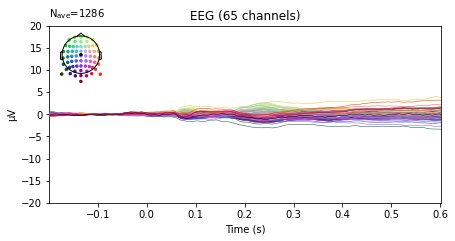

In [133]:
# Subject 8 standard condition
mne.viz.plot_evoked(combined_evoked_dict['008'][0], spatial_colors = True, ylim = dict(eeg = [-20, 20]));

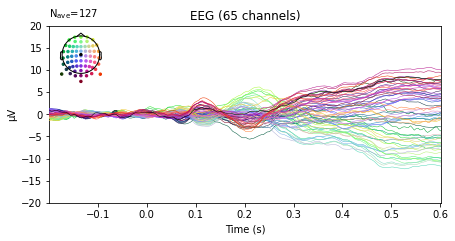

In [134]:
# Subject 8 oddball condition
mne.viz.plot_evoked(combined_evoked_dict['008'][1], spatial_colors = True, ylim = dict(eeg = [-20, 20]));

In [140]:
# Exclude subject 2 & 7 due to missing values
sub_exclude = [x for x in sub_index if x not in ['002', '007']]

def plot_all_evoked():
    for subj in sub_exclude:
        standard = combined_evoked_dict[subj][0]
        oddball = combined_evoked_dict[subj][1]
        
        print(f"Subject {subj} (Condition: standard)")
        mne.viz.plot_evoked(standard, spatial_colors = True, ylim = dict(eeg = [-20, 20]));
        
        print(f"Subject {subj} (Condition: oddball)")
        mne.viz.plot_evoked(oddball, spatial_colors = True, ylim = dict(eeg = [-20, 20]));
        
        print("--------------------------------------------------------------------\n\n")

Subject 001 (Condition: standard)


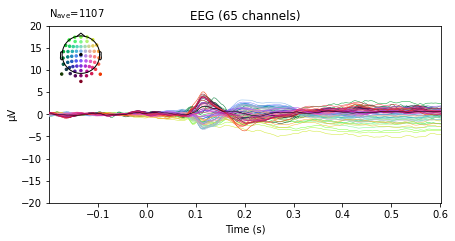

Subject 001 (Condition: oddball)


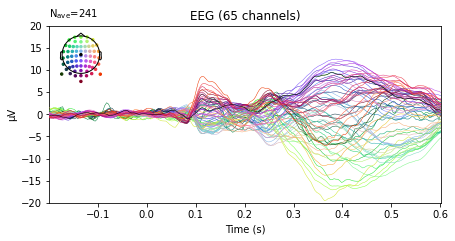

--------------------------------------------------------------------


Subject 003 (Condition: standard)


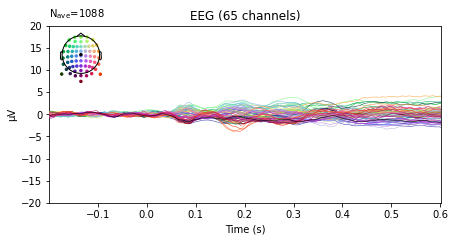

Subject 003 (Condition: oddball)


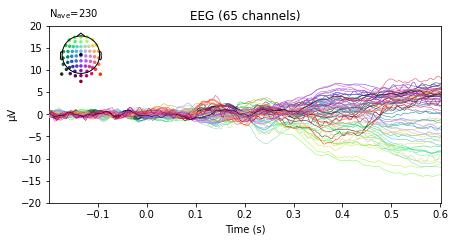

--------------------------------------------------------------------


Subject 004 (Condition: standard)


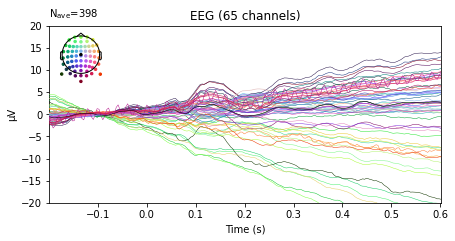

Subject 004 (Condition: oddball)


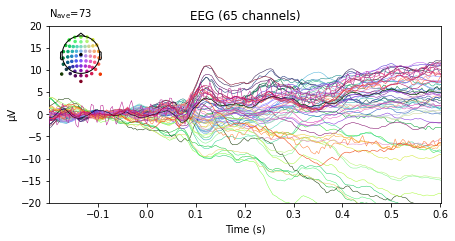

--------------------------------------------------------------------


Subject 005 (Condition: standard)


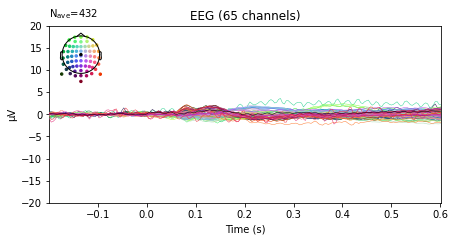

Subject 005 (Condition: oddball)


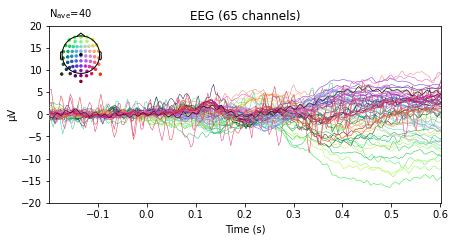

--------------------------------------------------------------------


Subject 006 (Condition: standard)


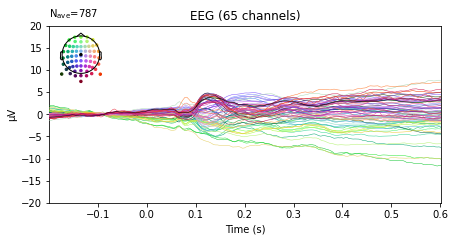

Subject 006 (Condition: oddball)


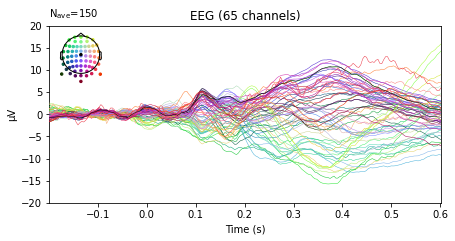

--------------------------------------------------------------------


Subject 008 (Condition: standard)


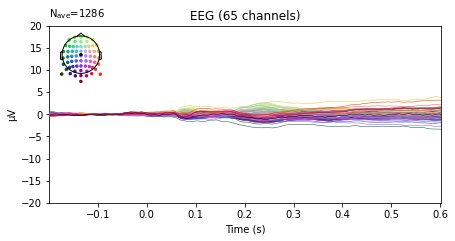

Subject 008 (Condition: oddball)


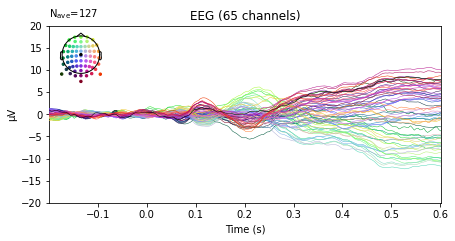

--------------------------------------------------------------------


Subject 009 (Condition: standard)


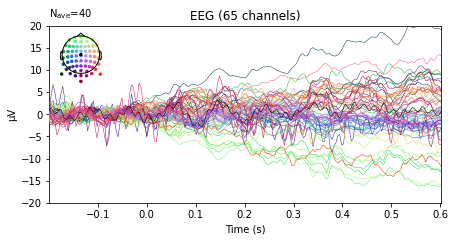

Subject 009 (Condition: oddball)


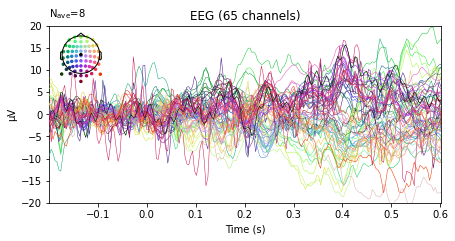

--------------------------------------------------------------------


Subject 010 (Condition: standard)


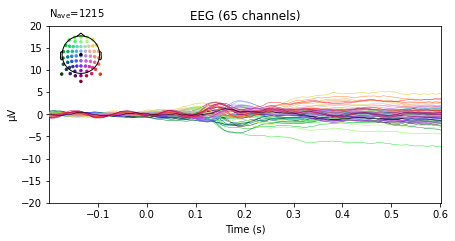

Subject 010 (Condition: oddball)


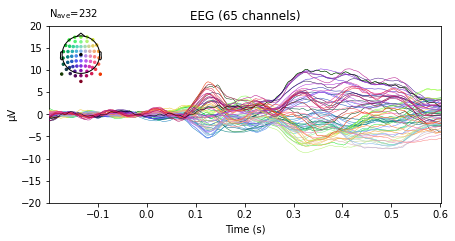

--------------------------------------------------------------------


Subject 011 (Condition: standard)


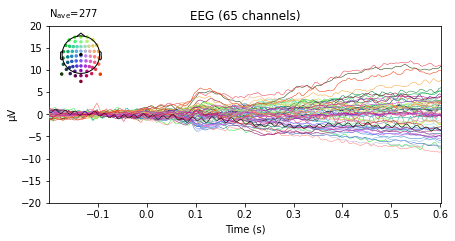

Subject 011 (Condition: oddball)


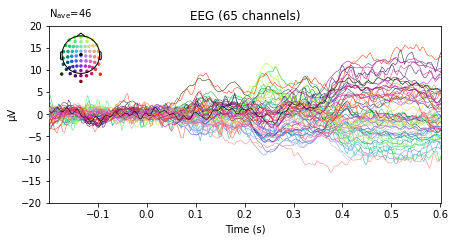

--------------------------------------------------------------------


Subject 012 (Condition: standard)


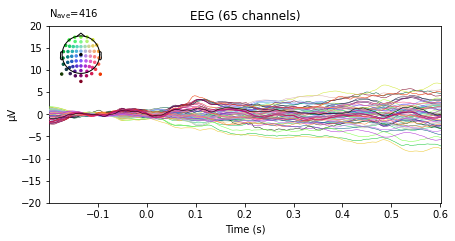

Subject 012 (Condition: oddball)


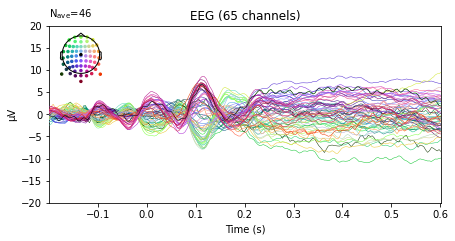

--------------------------------------------------------------------


Subject 013 (Condition: standard)


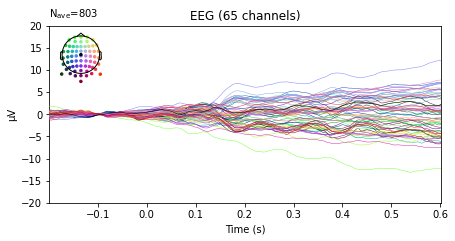

Subject 013 (Condition: oddball)


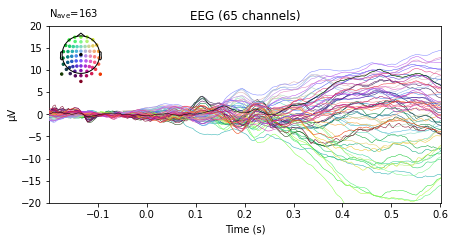

--------------------------------------------------------------------




In [141]:
plot_all_evoked()

## Plotting multiple channels using Amanda's rERP package

`pip install amanda_rerp_ols`

The following code is provided by TA Amanda Lin

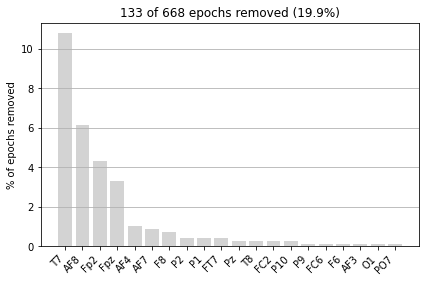

(535, 65, 206) 



[[(0.0, 0.0, 'oddball_with_reponse'), (0.5585939999999994, 0.0, 'response')],
 [(2.499999993688107e-07, 0.0, 'oddball_with_reponse')],
 [(2.499999993688107e-07, 0.0, 'oddball_with_reponse'),
  (0.46875024999999937, 0.0, 'response')],
 [(-2.499999993688107e-07, 0.0, 'oddball_with_reponse'),
  (0.36718774999999937, 0.0, 'response')],
 [(4.999999987376214e-07, 0.0, 'oddball_with_reponse'),
  (0.3671875, 0.0, 'response')],
 [(2.499999993688107e-07, 0.0, 'oddball_with_reponse'),
  (0.5234372500000006, 0.0, 'response')],
 [(0.0, 0.0, 'oddball_with_reponse'), (0.5390629999999987, 0.0, 'response')],
 [(2.499999993688107e-07, 0.0, 'oddball_with_reponse'),
  (0.5742192499999987, 0.0, 'response')],
 [(-2.499999993688107e-07, 0.0, 'oddball_with_reponse'),
  (0.48437475000000063, 0.0, 'response')],
 [(4.999999987376214e-07, 0.0, 'oddball_with_reponse')],
 [(-4.999999987376214e-07, 0.0, 'oddball_with_reponse')],
 [(0.0, 0.0, 'oddball_with_reponse'), (0.578125, 0.0, 'response')],
 [(2.499999993688107

In [146]:
new_epochs = epochs['standard', 'oddball_with_reponse']
conditions = ['standard', 'oddball_with_reponse']

drops = mne.viz.plot_drop_log(new_epochs.drop_log)
print(new_epochs.get_data().shape, '\n')
epochs_annot = new_epochs.get_annotations_per_epoch()
display([annot for annot in epochs_annot if annot[0][2] != 'standard'])

In [147]:
from amanda_rerp_ols import *

col1 = [1 if annot[0][2] == 'standard' else 0 for annot in epochs_annot]
col2 = [1 if annot[0][2] != 'standard' else 0 for annot in epochs_annot]
dm = np.array([col1, col2]).transpose()
res = rerp_ols(new_epochs, dm, pred_names=conditions)
print(type(res))

'''(num_conditions, num_channels, num_timepoints)'''
res.Coeffs['coeffs_arr'].shape

Fitting linear model to epochs, (13390 targets, 2 regressors)
Done
<class 'amanda_rerp_ols.my_functions.rERP_OLS_Wrapper'>


(2, 65, 206)

In [148]:
conditions_dict = {'standard':0, 'oddball_with_reponse':1}
'''amanda-rerp-ols calculates binned averages using regression (matrix operation in linear algebra)'''
res.Coeffs['coeffs_arr'][conditions_dict['standard']]

array([[ 3.00130538e-07,  2.69491634e-07,  1.92898717e-07, ...,
         5.76402836e-07,  5.12657925e-07,  4.35524481e-07],
       [-7.15642731e-07, -6.87350272e-07, -6.07850185e-07, ...,
         4.80594449e-07,  5.83284750e-07,  7.24986554e-07],
       [-5.70096139e-07, -5.47967069e-07, -4.66199455e-07, ...,
        -6.50514258e-07, -5.65335710e-07, -4.34992629e-07],
       ...,
       [ 4.11366100e-07,  2.78819469e-07,  1.14824244e-07, ...,
         5.92536322e-07,  3.61346900e-07,  1.16107519e-07],
       [ 1.93544419e-07,  2.36814357e-07,  2.29914904e-07, ...,
         3.67988730e-07,  1.65267749e-07, -5.55021074e-08],
       [ 3.17560519e-07,  2.86328720e-07,  2.08263014e-07, ...,
         5.71851490e-07,  5.08796301e-07,  4.32379554e-07]])

In [149]:
standard_data = evoked_standard.get_data()
standard_data

array([[ 3.00130538e-07,  2.69491634e-07,  1.92898717e-07, ...,
         5.76402836e-07,  5.12657925e-07,  4.35524481e-07],
       [-7.15642731e-07, -6.87350272e-07, -6.07850185e-07, ...,
         4.80594449e-07,  5.83284750e-07,  7.24986554e-07],
       [-5.70096139e-07, -5.47967069e-07, -4.66199455e-07, ...,
        -6.50514258e-07, -5.65335710e-07, -4.34992629e-07],
       ...,
       [ 4.11366100e-07,  2.78819469e-07,  1.14824244e-07, ...,
         5.92536322e-07,  3.61346900e-07,  1.16107519e-07],
       [ 1.93544419e-07,  2.36814357e-07,  2.29914904e-07, ...,
         3.67988730e-07,  1.65267749e-07, -5.55021074e-08],
       [ 3.17560519e-07,  2.86328720e-07,  2.08263014e-07, ...,
         5.71851490e-07,  5.08796301e-07,  4.32379554e-07]])

In [150]:
'''Proving that the regression method is identical to usual averaging (except for rounding error)'''
discrepency = 0
for i in range(standard_data.shape[0]):
    for j in range(standard_data.shape[1]):
        if abs(mV(standard_data[i][j]) - mV(res.Coeffs['coeffs_arr'][conditions_dict['standard']][i][j])) >= 10**(-10):
            discrepency += 1
discrepency

0

In [151]:
from collections import OrderedDict

def create_ch_dict(obj):
    ch_list = obj.ch_names
    ch_dict = OrderedDict()
    for i in range(len(ch_list)): ch_dict.update({ch_list[i]: i})
    return ch_dict 

ch_dict = create_ch_dict(raw)
print(ch_dict, '\n')
print(ch_dict['POz'])

OrderedDict([('Fp1', 0), ('AF7', 1), ('AF3', 2), ('F1', 3), ('F3', 4), ('F5', 5), ('F7', 6), ('FT7', 7), ('FC5', 8), ('FC3', 9), ('FC1', 10), ('C1', 11), ('C3', 12), ('C5', 13), ('T7', 14), ('TP7', 15), ('CP5', 16), ('CP3', 17), ('CP1', 18), ('P1', 19), ('P3', 20), ('P5', 21), ('P7', 22), ('P9', 23), ('PO7', 24), ('PO3', 25), ('O1', 26), ('Iz', 27), ('Oz', 28), ('POz', 29), ('Pz', 30), ('CPz', 31), ('Fpz', 32), ('Fp2', 33), ('AF8', 34), ('AF4', 35), ('AFz', 36), ('Fz', 37), ('F2', 38), ('F4', 39), ('F6', 40), ('F8', 41), ('FT8', 42), ('FC6', 43), ('FC4', 44), ('FC2', 45), ('FCz', 46), ('Cz', 47), ('C2', 48), ('C4', 49), ('C6', 50), ('T8', 51), ('TP8', 52), ('CP6', 53), ('CP4', 54), ('CP2', 55), ('P2', 56), ('P4', 57), ('P6', 58), ('P8', 59), ('P10', 60), ('PO8', 61), ('PO4', 62), ('O2', 63), ('EXG1', 64), ('EXG2', 65), ('EXG3', 66), ('EXG4', 67), ('EXG5', 68), ('EXG6', 69), ('EXG7', 70), ('EXG8', 71), ('GSR1', 72), ('GSR2', 73), ('Erg1', 74), ('Erg2', 75), ('Resp', 76), ('Plet', 77), (

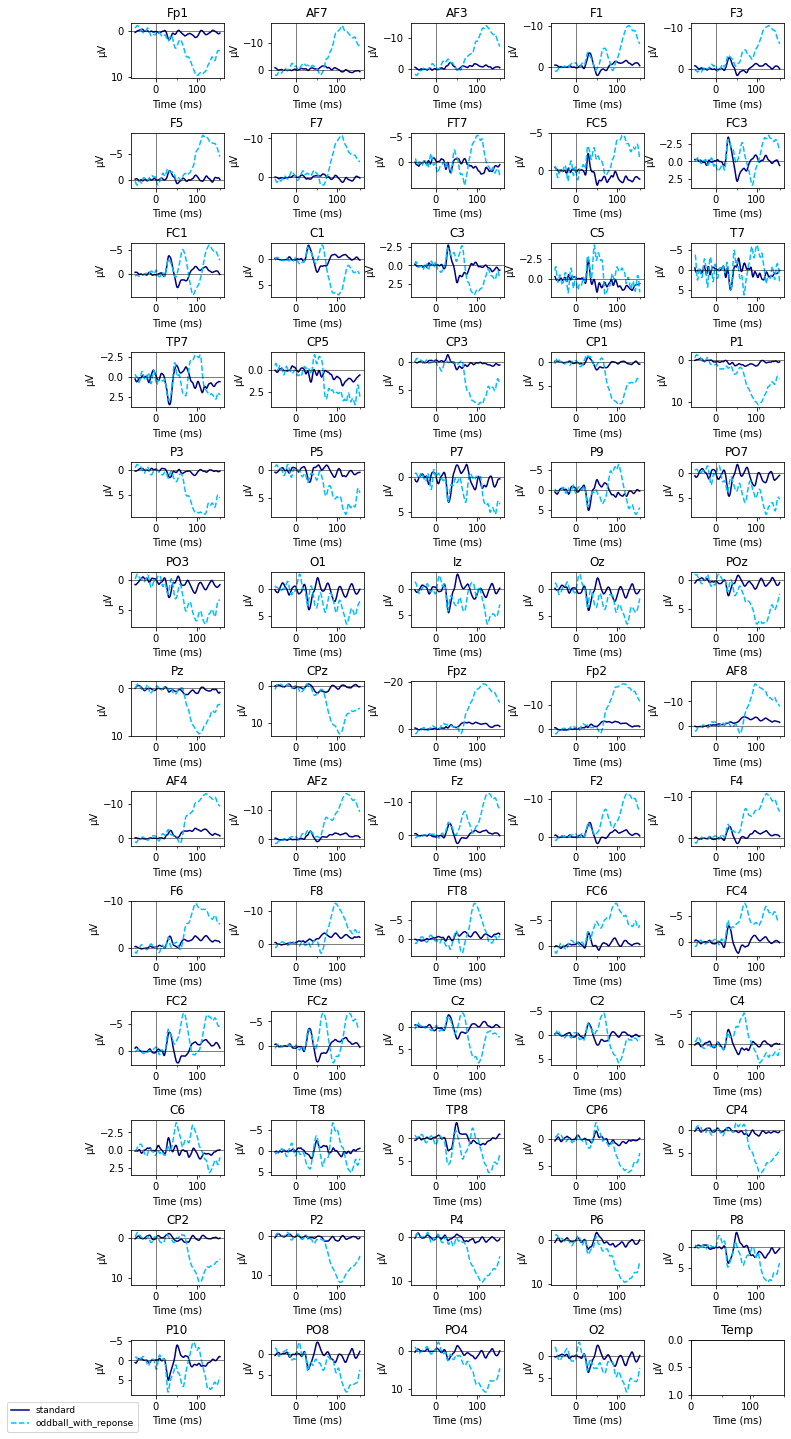

In [153]:
import warnings
warnings.filterwarnings('ignore')

t = [i for i in range(-50, 156)]
linestyles = ['solid','dashed']
colors = ['navy','deepskyblue']

'''The P3b effect is most prominet in posterior regions, so you can easily see the robust effects at P-channels.'''
figure, axes = plt.subplots(13,5, figsize=(10, 20))
for ax, ch in zip(axes.flatten(), new_epochs.ch_names):
    for i, x in enumerate(conditions):
        try: ax.plot(t, mV(res.Coeffs['coeffs_arr'][i][ch_dict[ch]]), linestyle=linestyles[i], color=colors[i], label=x)
        except: pass
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.set_title(ch)
    ax.set_xlabel('Time (ms)')
    ax.set_xticks([0, 52, 104, 156], ['-200', '0', '400', '600'])
    ax.set_ylabel('µV')
    ax.invert_yaxis()
hdl, lbl = axes.flatten()[-2].get_legend_handles_labels()
figure.legend(hdl, lbl, loc='lower left', fontsize='9', bbox_to_anchor=[-0.1, 0.00001])
figure.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show() 